all plots of interest for fitting models of 1-4 layers to data of a 3 layer model.

for each above has no limit on max thickness\
below has a limits of punishish ing the fitting of total thickness > 350 (for the varying slabs)

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
from sepObjectiveGO import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from CFitter import CFitter
import make_sim_data as msd
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))


refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4
refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


In [2]:
def aPlotter(res, interestingNo, spacesize, figI):
    print(figI)
    # no = -1000
    # slc = slice(no-1000,no)
    useAbleLow=0.1
    useAbleHigh=10.
    xall=np.linspace(0,spacesize,len(res["logz"]))
    print("len",len(res["logz"]), "space size", spacesize)
    useable=np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if np.exp(y)>useAbleLow and np.exp(y)<=useAbleHigh]))
    # print(len(res["logz"]),res["logz"][slc])#summary()
    interesting = np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if x>=float(interestingNo)]))#.reshape((2,-2))
#     print("len 2", len(interesting[0]), len(interesting), interesting[0,:3])
    print("logz max: ",max(res["logz"]),",min: ",min(res["logz"]))
    print("z max: ",max(np.exp(res["logz"])),",min: ",min(np.exp(res["logz"])))
#     print(res["logz"][:5],interesting[1,:5],useable[1,:5])
    # print("interesting")
#     xall=np.linspace(0,spacesize,len(res["logz"]))
#     xusable=np.linspace(0,spacesize,len(useable))
    plt.figure(figI)
    figI+=1
    if len(useable)>=2:
        n_plots = 3
    else:
        n_plots = 2
    plt.subplot(1, n_plots, 1)
    plt.plot(xall,res["logz"])
    if any([lnz<=0 for lnz in res["logz"]]):
        plt.title("ln(evidence)\n not log scaled vs -ln(X)")
        plt.plot(xall, [0 for value in xall], label="ln(evidence)=0", alpha=0.4,linestyle="--")
    else:
        plt.title("ln(evidence)\n log scaled vs -ln(X)")
        plt.yscale("log")
    plt.xlabel("-ln(X)")
    plt.ylabel("ln(evidence)")
#     plt.figure(figI)
#     figI+=1
    plt.subplot(1, n_plots, 2)
    plt.plot(interesting[0],interesting[1])
    plt.title("interesting values\n ln(evidence)\n"+r" vs -ln(X) $\geq %d$" % interestingNo)
    plt.xlabel("-ln(X)")
    plt.ylabel("ln(evidence)")
    if len(useable)>=2:
        plt.subplot(1, n_plots, 3)
        plt.plot(useable[0],useable[1])
        plt.title("usful values\n"+r"ln(%.3f<evidence $\leq$ %.3f) vs -ln(X)"%(useAbleLow,useAbleHigh))
        plt.xlabel("-ln(X)")
        plt.ylabel("ln(evidence)")
    else:
        print("not enough 'usable' data points")
    print(figI)
    plt.tight_layout()
    return figI

In [3]:
# def min_interesting_lnX(res):
#     returns = None
# #     returns = min([-lnX for lnX, wt in zip(res["logvol"], np.exp(res['logwt'] - res['logz'][-1])) if wt>0])
#     returns = [(-lnX,wt) for lnX, wt in zip(res["logvol"], np.exp(res['logwt'] - res['logz'][-1])) if wt>0.001]
#     return returns

def min_interesting_lnX(res):
    returns = None
    for lnX, logz in zip(res["logvol"], res['logz']):
        if logz >= 0.:
            break
        else:
            returns = -lnX
#     returns = min([-lnX for lnX, wt in zip(res["logvol"], np.exp(res['logwt'] - res['logz'][-1])) if wt>0])
    return returns

maxLength = 350
def logp_extra(model, data=None):
    returns = 0
    if sum(model.structure.slabs()[1:-1,0])>maxLength:
        returns = -np.inf
    return returns

In [4]:
figI = 0
# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
# no_layers = len(bs_true)
# no_layers = 3
layers1 = []
layers2 = []
names = []
#names = ['layer1','layer2']
contrast_layer = 1
bs_contrast_layer = 6
thicks_contrast_layer=Parameter(thicks[contrast_layer],
                                "layer1 thickness")
roughs_contrast_layer=Parameter(roughs[contrast_layer],
                                "layer0/contrast roughness")
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
    if i != contrast_layer:
        sld = SLD(bs[i],name=names[i])
        sld = sld(thicks[i],roughs[i])
        layers1.append(sld)
        layers2.append(sld)
    else:
        sld1 = SLD(bs[i],name=names[i]+" contrast a")
        sld1 = sld1(thicks_contrast_layer,roughs_contrast_layer)
        sld2 = SLD(bs_contrast_layer,name=names[i]+" contrast b")
        sld2 = sld2(thicks_contrast_layer,roughs_contrast_layer)
        layers1.append(sld1)
        layers2.append(sld2)

structure1 = layers1[0]
for layer in layers1[1:]:
    structure1|=layer

structure2 = layers2[0]
for layer in layers2[1:]:
    structure2|=layer
print("done")

done


done


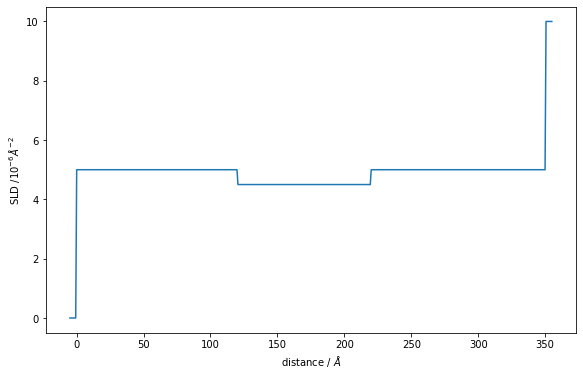

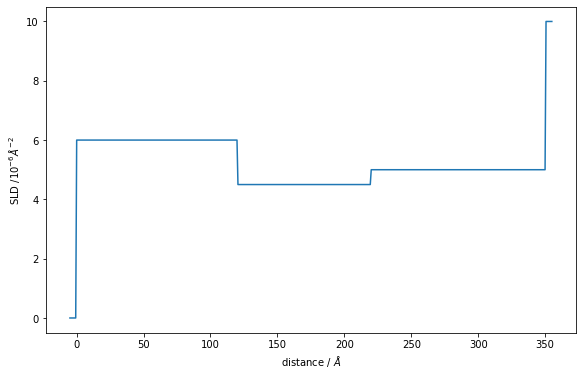

In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.figure(figI)
figI+=1
plt.plot(*structure1.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

plt.figure(figI)
figI+=1
plt.plot(*structure2.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
print("done")

In [6]:
resolution = 5.
model1 = ReflectModel(structure1, bkg=3e-6, dq=resolution)
model2 = ReflectModel(structure2, bkg=3e-6, dq=resolution)

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01

<ErrorbarContainer object of 3 artists>

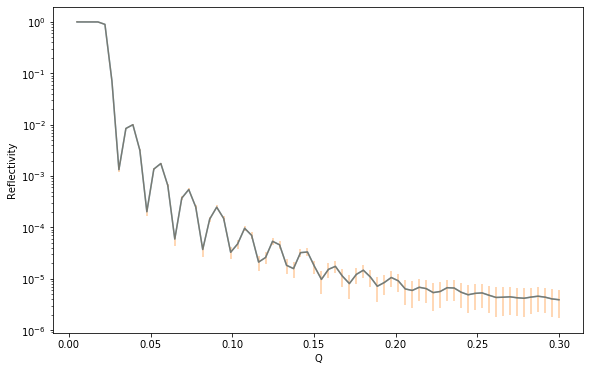

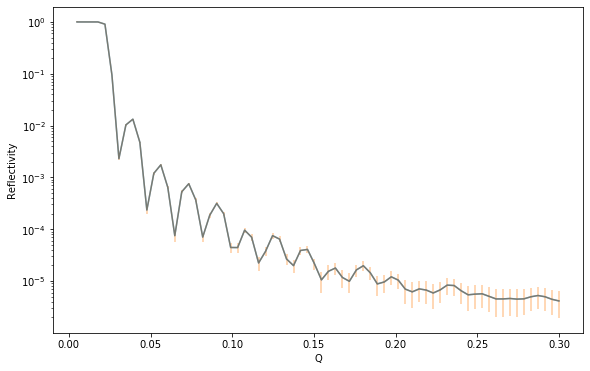

In [7]:
q = np.linspace(0.005, 0.3, 70)# was 1001 no 70
plt.figure(figI)
figI+=1
R1 = model1(q, x_err=resolution)
plt.plot(q, R1)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.yscale('log')
sim_dR1 = msd.main(sim_q=q,sim_R=R1)*10
plt.errorbar(q,R1,sim_dR1, alpha=0.4)

q = np.linspace(0.005, 0.3, 70)# was 1001 no 70
plt.figure(figI)
figI+=1
R2 = model2(q, x_err=resolution)
plt.plot(q, R2)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.yscale('log')
sim_dR2 = msd.main(sim_q=q,sim_R=R2)*10
plt.errorbar(q,R2,sim_dR2, alpha=0.4)

In [8]:
data = [Data1D(data= (q,R1,sim_dR1)),Data1D(data= (q,R2,sim_dR2))]

In [9]:
# # from sepObjective import getObjective as gO
# objective = gO(data, 3)
# # from CFitter import CFitter
# # def ex
# fitter = CFitter(objective)
# # from dynesty import DynamicNestedSampler
# DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
# DNSampler.run_nested(dlogz_init=0.01)
# res = DNSampler.results # 07:18 mins


In [10]:
# res.summary()

summary() doesnt seem useable for dynamic sampling.\
MultiEllipsoidSamplerSamples conditioned on the union of multiple (possibly overlapping) ellipsoids used to bound the set of live points.

calculation is taking ln(z) = ln(evidence) and taking the exponent

In [11]:
# fig, ax = objective.plot()
# figI+=1
# plt.figure(figI)
# figI+=1
# plt.plot(*structure.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

In [12]:
# span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**1)]
# fig, axes = dyplot.runplot(res,span=span, color='black', mark_final_live=False,
#                            logplot=False)
# fig.tight_layout()

In [13]:
# figI = aPlotter(res, 19, 35, figI)

In [14]:
# fig, axes = dyplot.traceplot(res, truths=np.zeros(fitter.nDim()),
#                              show_titles=True, trace_cmap='plasma',
#                              quantiles=None,
#                            logplot=False)
# fig.tight_layout()

## 1 layered

In [38]:
objective1, structure11, structure12 = gO(data, 1, both=True, globalObjective=True) # was 06:09 now 0:36
fitter = CFitter(objective1)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res11 = DNSampler.results

objective2, structure21, structure22 = gO(data, 1,
                 logpExtra=logp_extra, both=True, globalObjective=True)
fitter = CFitter(objective2)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res12 = DNSampler.results

GlobalObjective and 2 structures


37671it [14:13, 44.14it/s, batch: 7 | bound: 188 | nc: 1 | ncall: 168873 | eff(%): 22.307 | loglstar: -4740.201 < -4731.103 < -4733.110 | logz: -4765.010 +/-  0.336 | stop:  0.961]    


GlobalObjective and 2 structures


39782it [16:50, 39.36it/s, batch: 7 | bound: 188 | nc: 1 | ncall: 166262 | eff(%): 23.927 | loglstar: -4740.662 < -4730.714 < -4733.450 | logz: -4765.393 +/-  0.336 | stop:  0.817]    


previous\
21713it [04:36, 78.66it/s, batch: 9 | bound: 66 | nc: 1 | ncall: 64560 | eff(%): 33.632 | loglstar: -1811.602 < -1805.361 < -1805.882 | logz: -1818.340 +/-  0.211 | stop:  0.955]\
pre previous\
25968it [06:09, 70.27it/s, batch: 10 | bound: 81 | nc: 1 | ncall: 75806 | eff(%): 34.256 | loglstar: -44363.849 < -44357.543 < -44357.955 | logz: -44375.162 +/-  0.250 | stop:  0.975] 

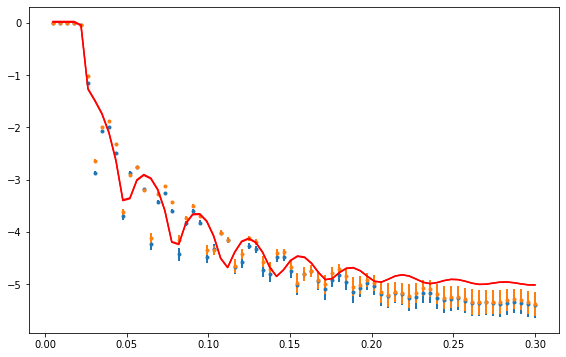

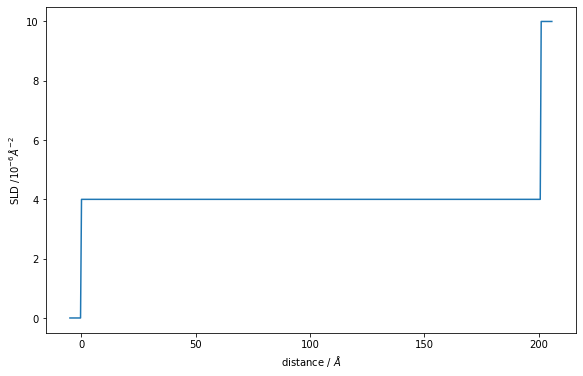

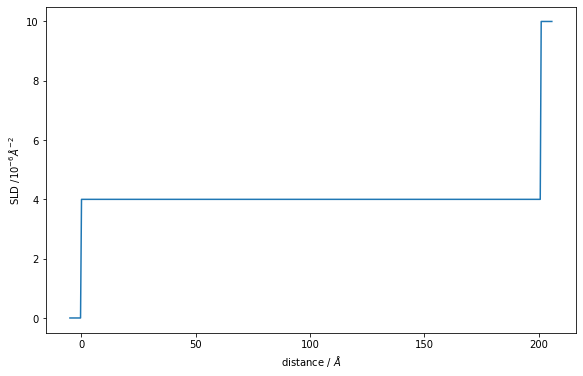

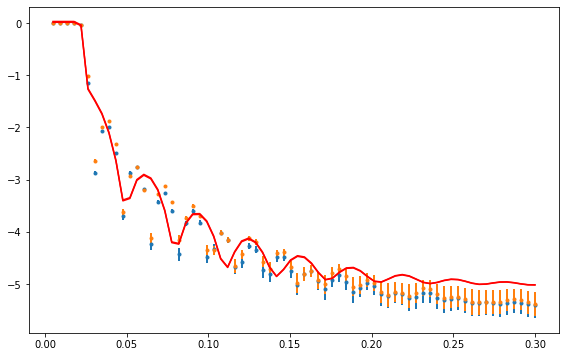

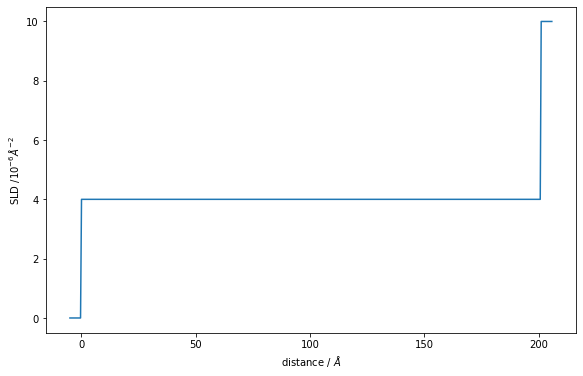

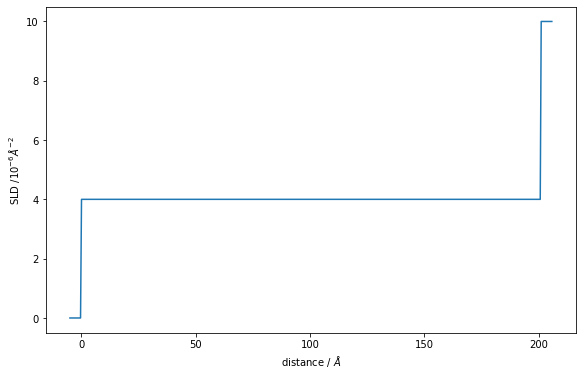

In [39]:
fig, ax = objective1.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure11.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.figure(figI)
figI+=1
plt.plot(*structure12.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

fig, ax = objective2.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure21.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.figure(figI)
figI+=1
plt.plot(*structure22.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

previous failed, fitting two at once

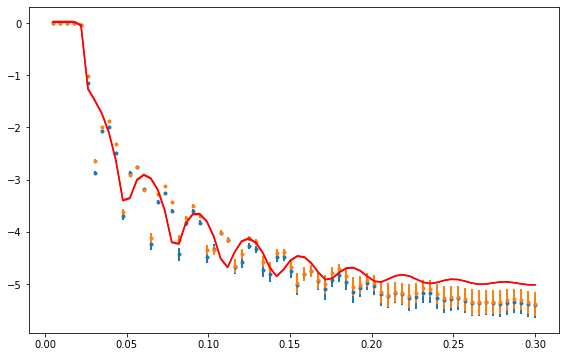

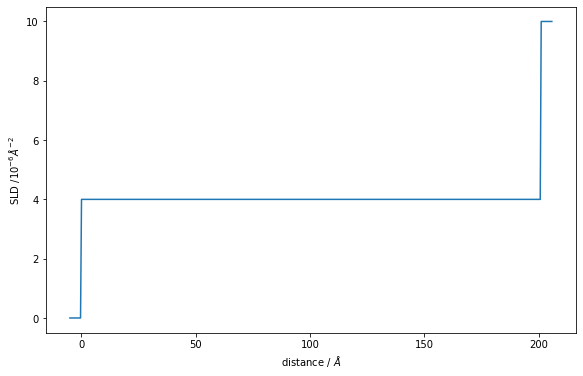

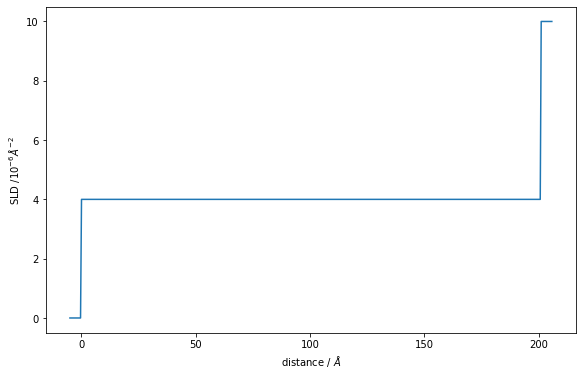

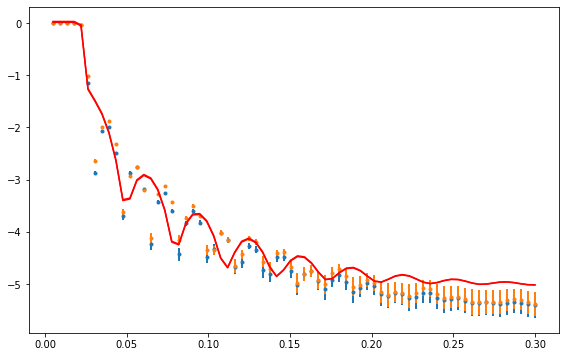

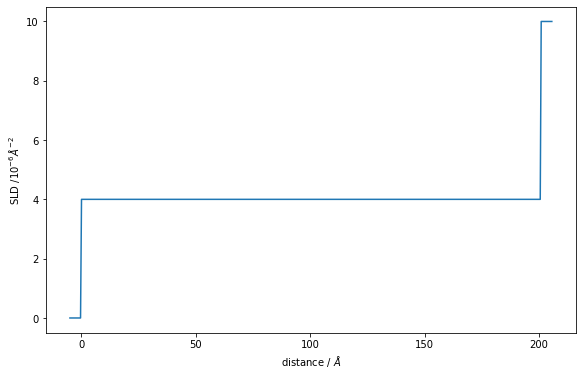

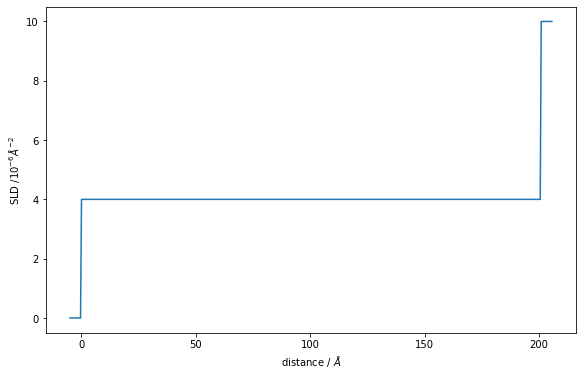

In [17]:
# fig, ax = objective1.plot()
# figI+=1
# plt.figure(figI)
# figI+=1
# plt.plot(*structure11.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');
# plt.figure(figI)
# figI+=1
# plt.plot(*structure12.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

# fig, ax = objective2.plot()
# figI+=1
# plt.figure(figI)
# figI+=1
# plt.plot(*structure21.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');
# plt.figure(figI)
# figI+=1
# plt.plot(*structure22.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

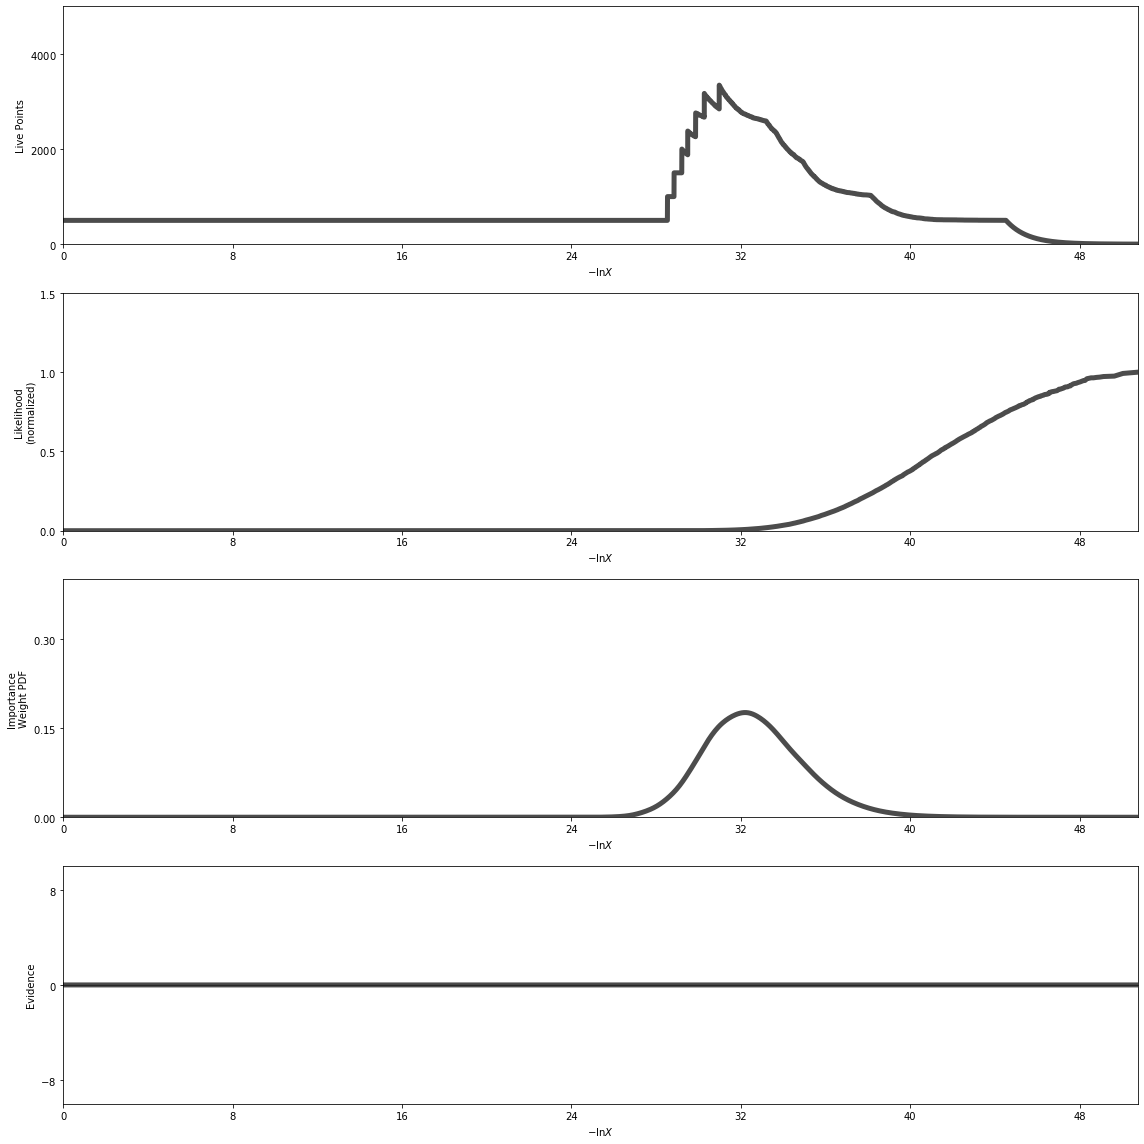

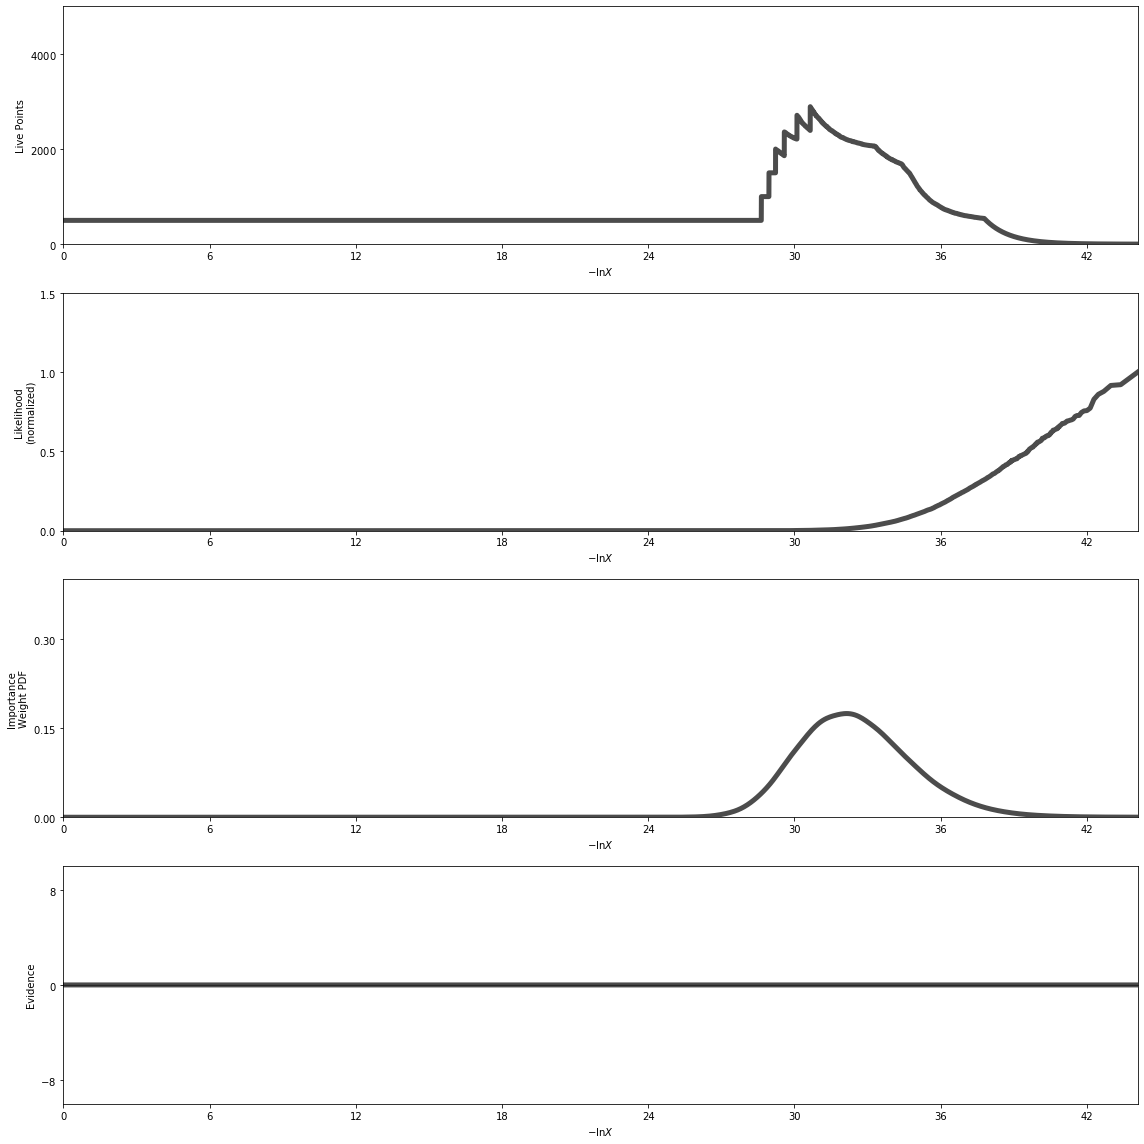

In [18]:
span = [(0,5000),(0,1.5),(0,0.4),(-10**1,10**1)]
fig, axes = dyplot.runplot(res11,span=span, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

span = [(0,5000),(0,1.5),(0,0.4),(-10**1,10**1)]
fig, axes = dyplot.runplot(res12,span=span, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

limit for interesting values from ln(evidence) >= 0
16
len 37810 space size 50.73744207051742
logz max:  -4765.11077361671 ,min:  -63592.378576617135
z max:  0.0 ,min:  0.0
not enough 'usable' data points
17
17
len 30015 space size 44.08185210726466
logz max:  -4764.967975132715 ,min:  -59388.3138562359
z max:  0.0 ,min:  0.0
not enough 'usable' data points
18


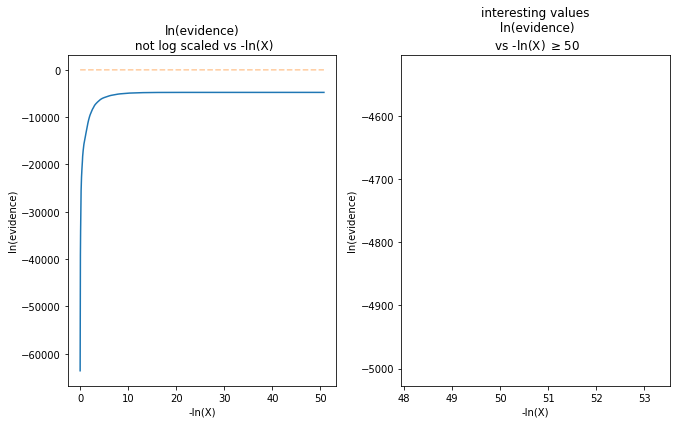

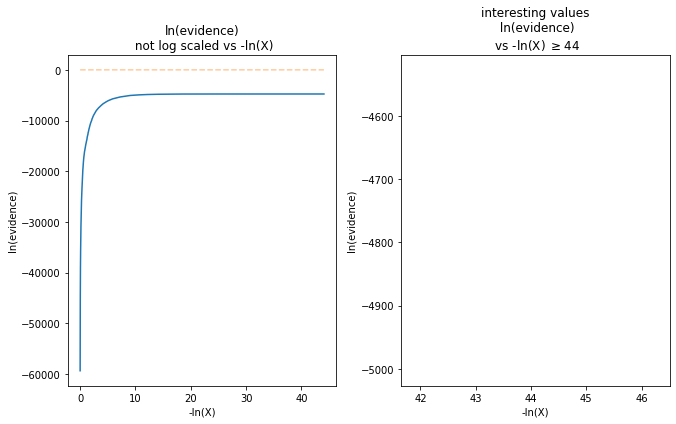

In [19]:
print("limit for interesting values from ln(evidence) >= 0")
figI = aPlotter(res11, min_interesting_lnX(res11), -min(res11["logvol"]), figI)

figI = aPlotter(res12, min_interesting_lnX(res12), -min(res12["logvol"]), figI)

In [20]:
print(-min(res11["logvol"]))

50.73744207051742


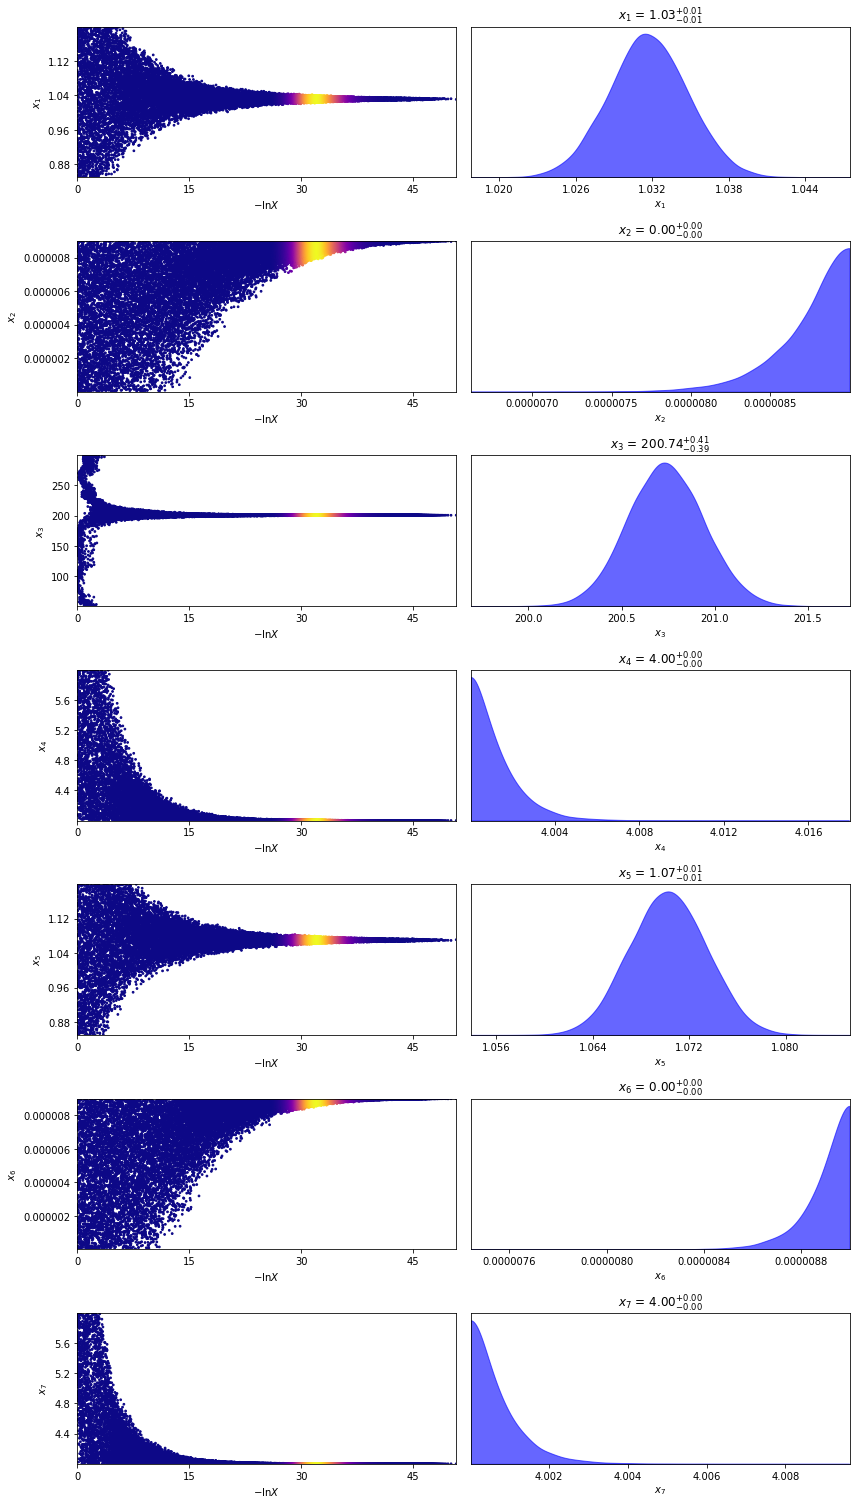

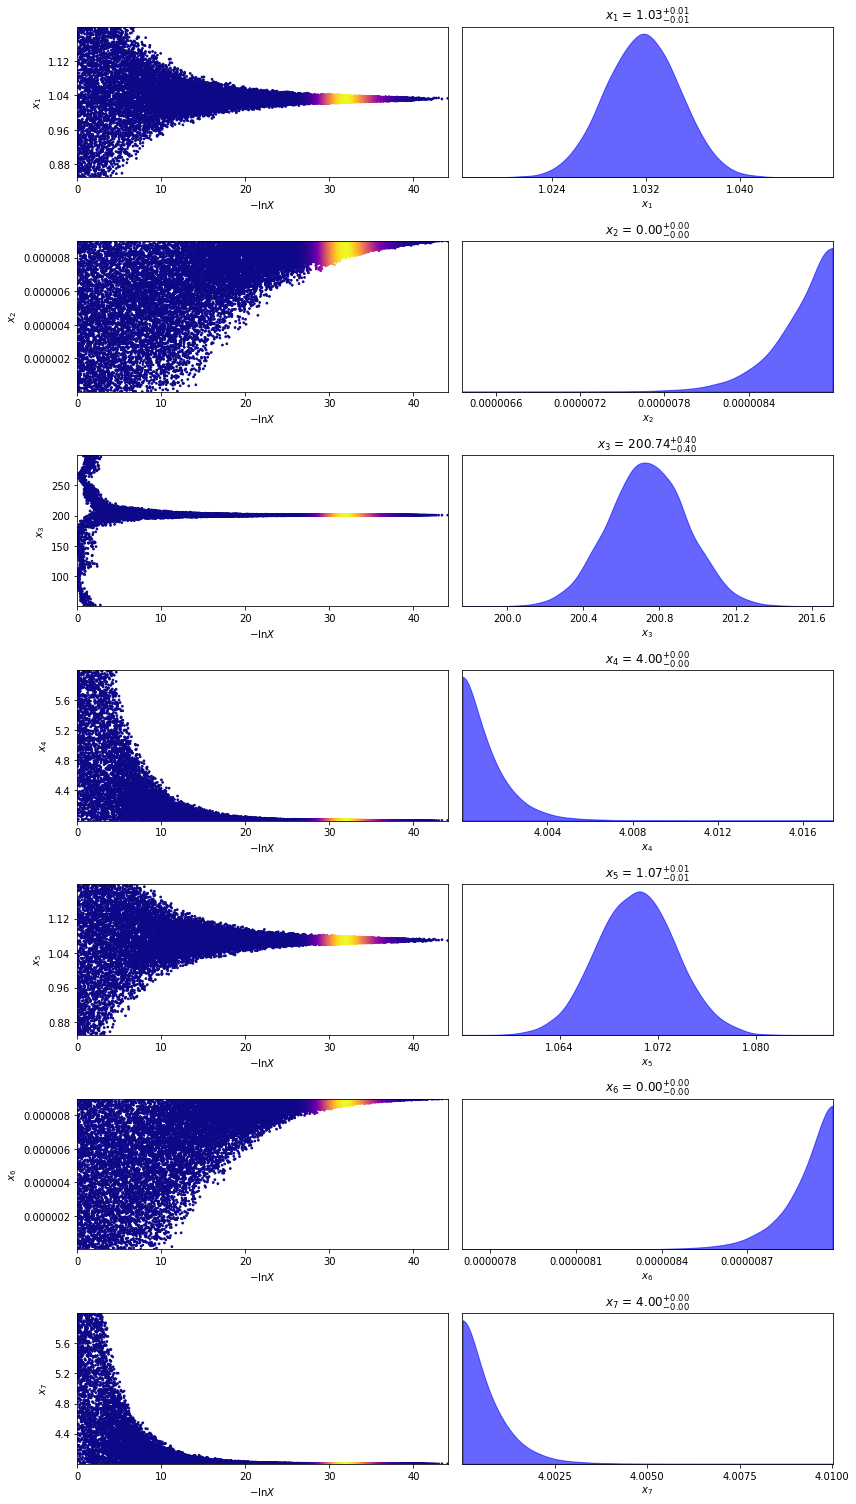

In [21]:
fig, axes = dyplot.traceplot(res11, #truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()

fig, axes = dyplot.traceplot(res12, #truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()

## 2 layered

In [22]:
objective1, structure11, structure12 = gO(data, 2, both=True, globalObjective=True) # was 06:09 now 0:36
fitter = CFitter(objective1)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res21 = DNSampler.results

objective2, structure21, structure22 = gO(data, 2,
                 logpExtra=logp_extra, both=True, globalObjective=True)
fitter = CFitter(objective2)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res22 = DNSampler.results


GlobalObjective and 2 structures


29646it [10:19, 47.86it/s, batch: 7 | bound: 146 | nc: 5 | ncall: 132240 | eff(%): 22.418 | loglstar: 174.940 < 183.914 < 181.666 | logz: 154.555 +/-  0.311 | stop:  0.914]            


GlobalObjective and 2 structures


29724it [11:37, 42.63it/s, batch: 7 | bound: 173 | nc: 5 | ncall: 154322 | eff(%): 19.261 | loglstar: 174.897 < 184.089 < 181.229 | logz: 154.846 +/-  0.308 | stop:  0.928]            


previous\
24152it [05:21, 75.10it/s, batch: 9 | bound: 79 | nc: 2 | ncall: 76847 | eff(%): 31.429 | loglstar: 78.380 < 85.912 < 85.243 | logz: 72.686 +/-  0.202 | stop:  0.836] \
pre previous\
24744it [05:20, 77.20it/s, batch: 8 | bound: 74 | nc: 1 | ncall: 70332 | eff(%): 35.182 | loglstar: 1241.354 < 1247.885 < 1247.372 | logz: 1228.828 +/-  0.255 | stop:  0.951]

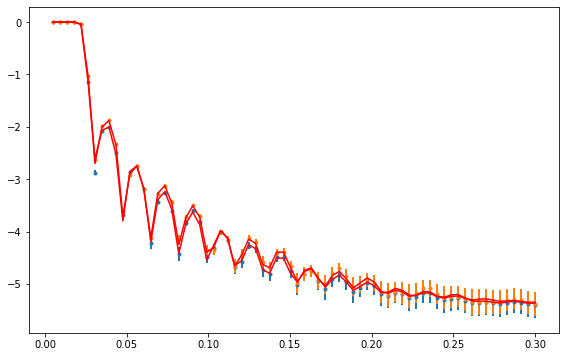

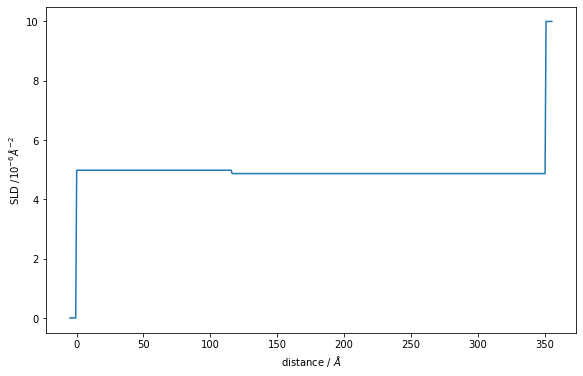

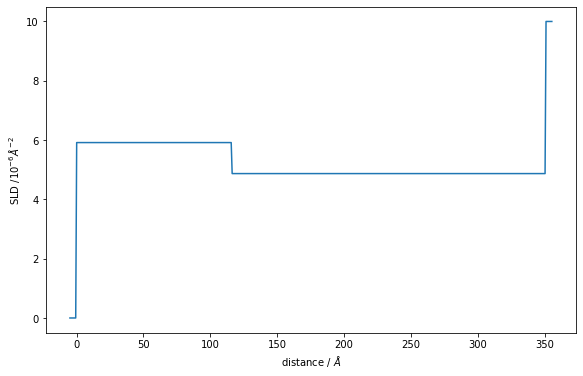

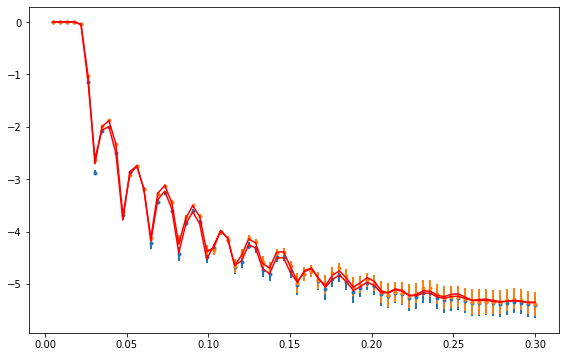

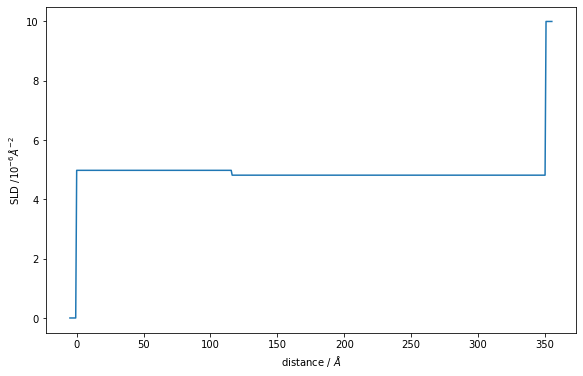

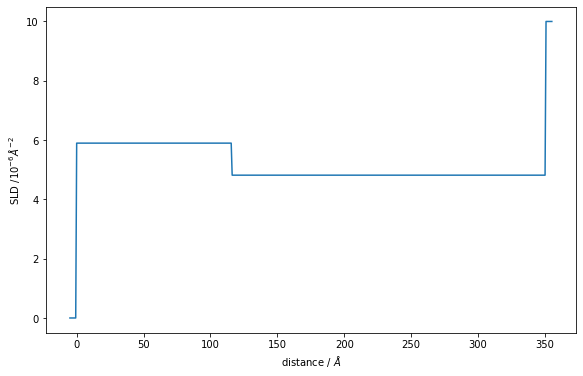

In [23]:
fig, ax = objective1.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure11.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.figure(figI)
figI+=1
plt.plot(*structure12.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

fig, ax = objective2.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure21.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.figure(figI)
figI+=1
plt.plot(*structure22.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

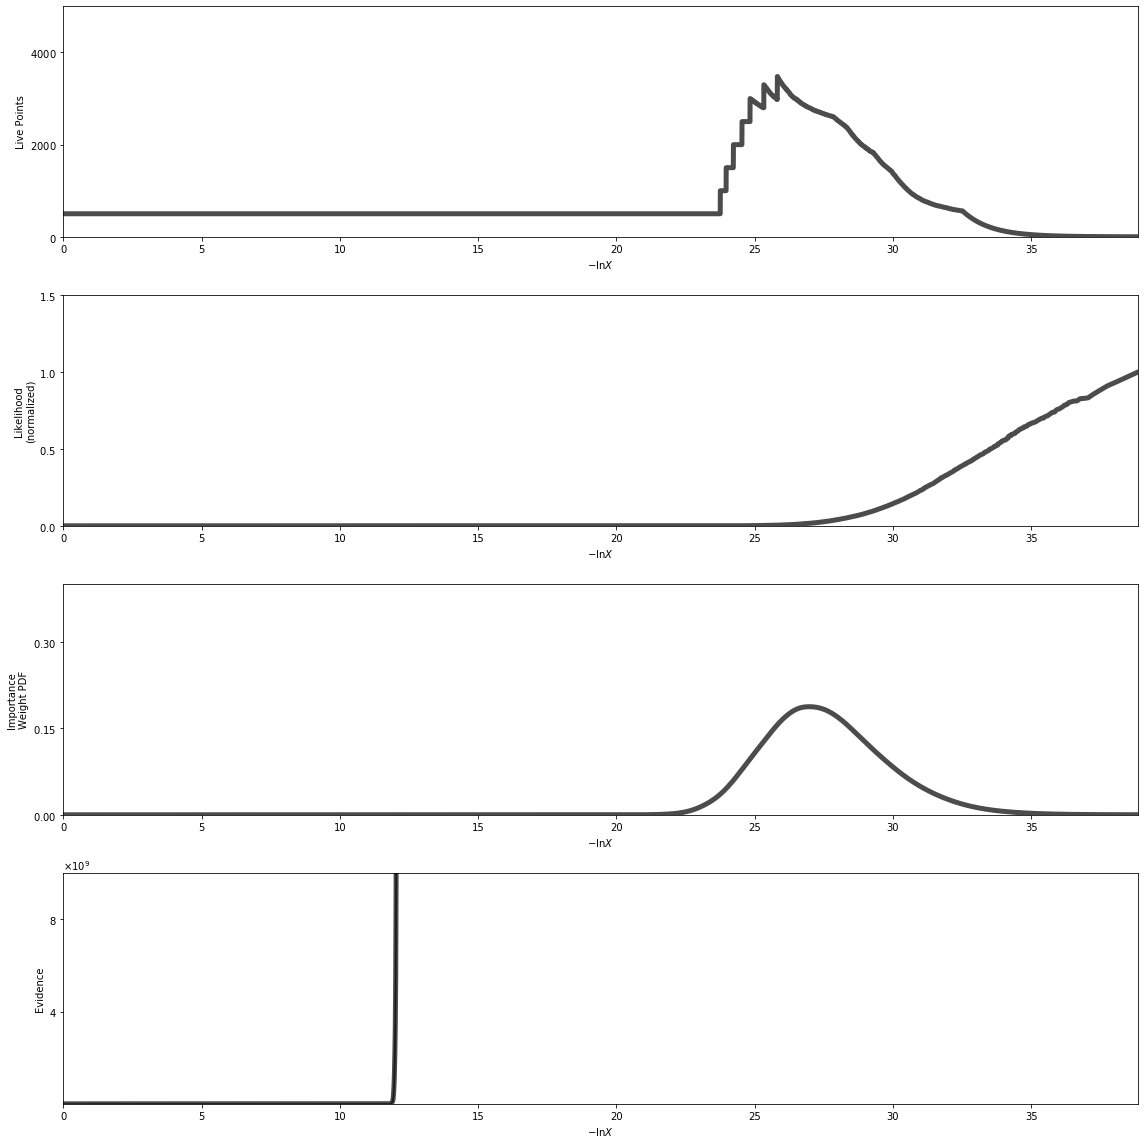

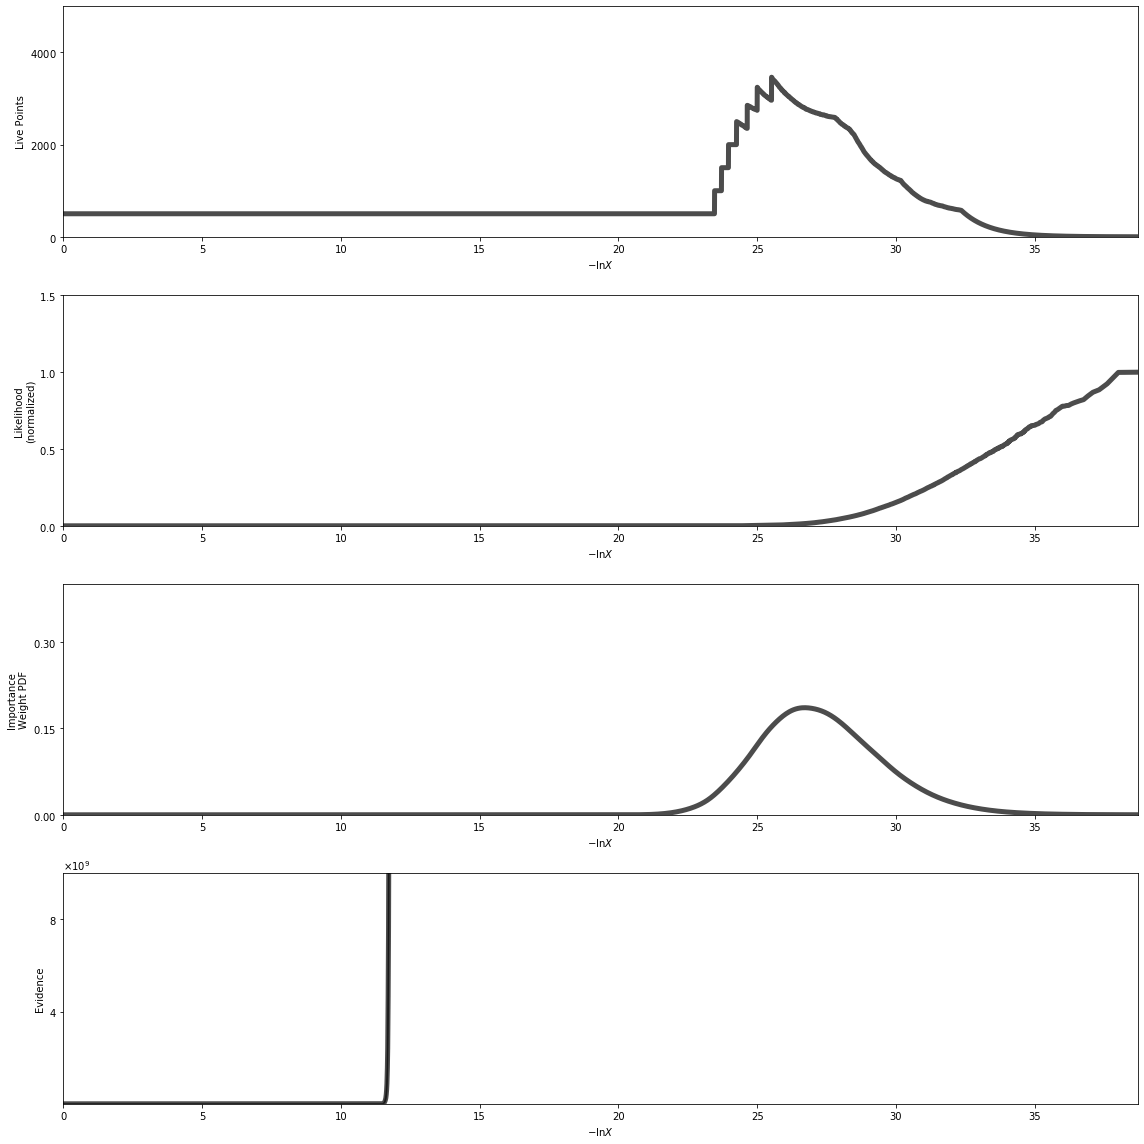

In [24]:
span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**10)]
fig, axes = dyplot.runplot(res21,span=span, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**10)]
fig, axes = dyplot.runplot(res22,span=span, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

In [25]:
# print(min_interesting_lnX(res22),min_interesting_itr_lnX(res22))

limit for interesting values from ln(evidence) >= 0
24
len 29646 space size 38.70963300064113
logz max:  154.5666450526567 ,min:  -52816.74295396885
z max:  1.341037840544807e+67 ,min:  0.0
25
25
len 29724 space size 38.70963300064113
logz max:  154.8144867405798 ,min:  -50219.072390215275
z max:  1.7182142246190373e+67 ,min:  0.0
26


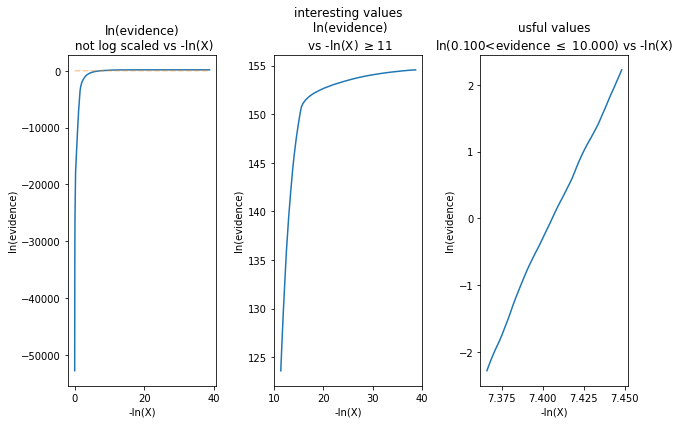

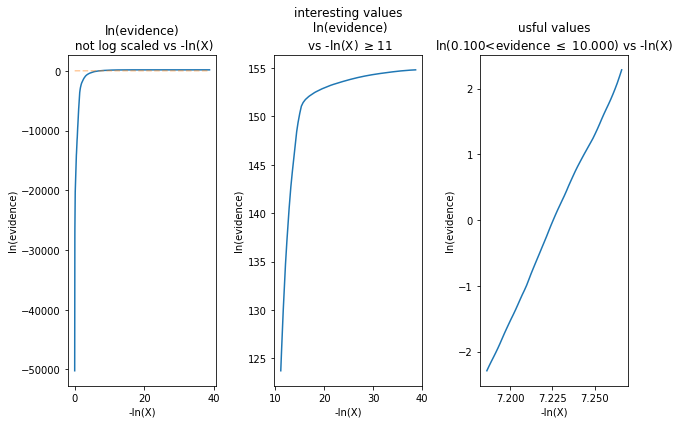

In [26]:
print("limit for interesting values from ln(evidence) >= 0")

figI = aPlotter(res21, min_interesting_lnX(res21), -min(res22["logvol"]), figI)

figI = aPlotter(res22, min_interesting_lnX(res22), -min(res22["logvol"]), figI)

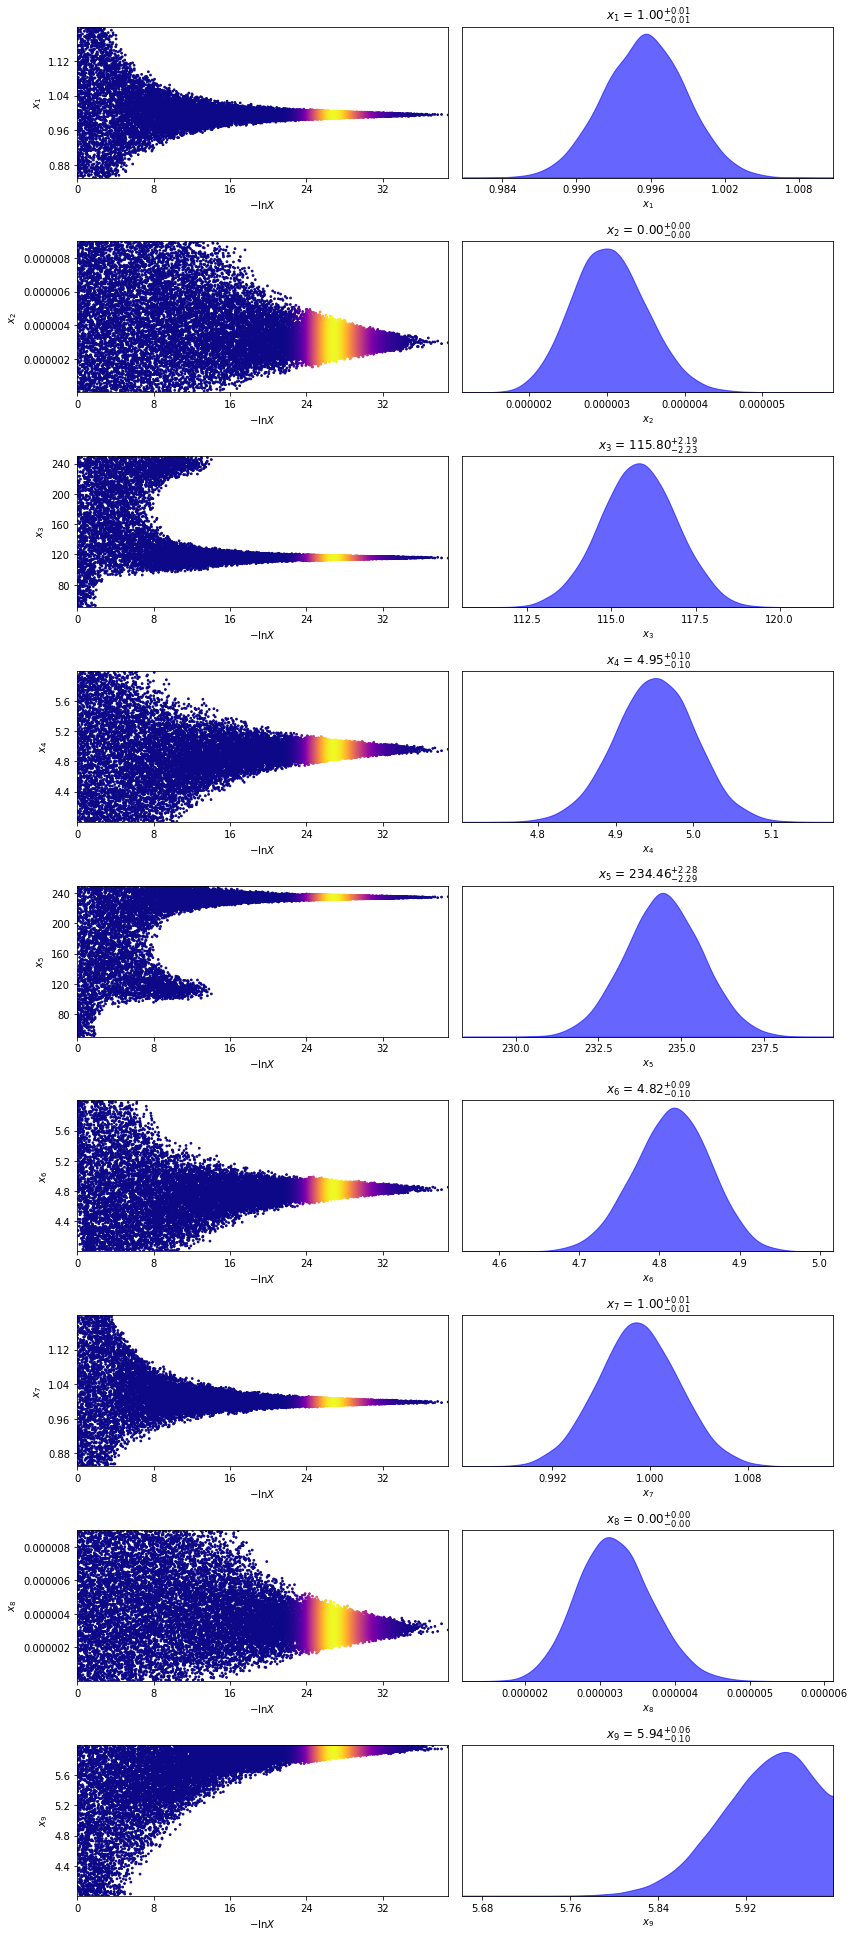

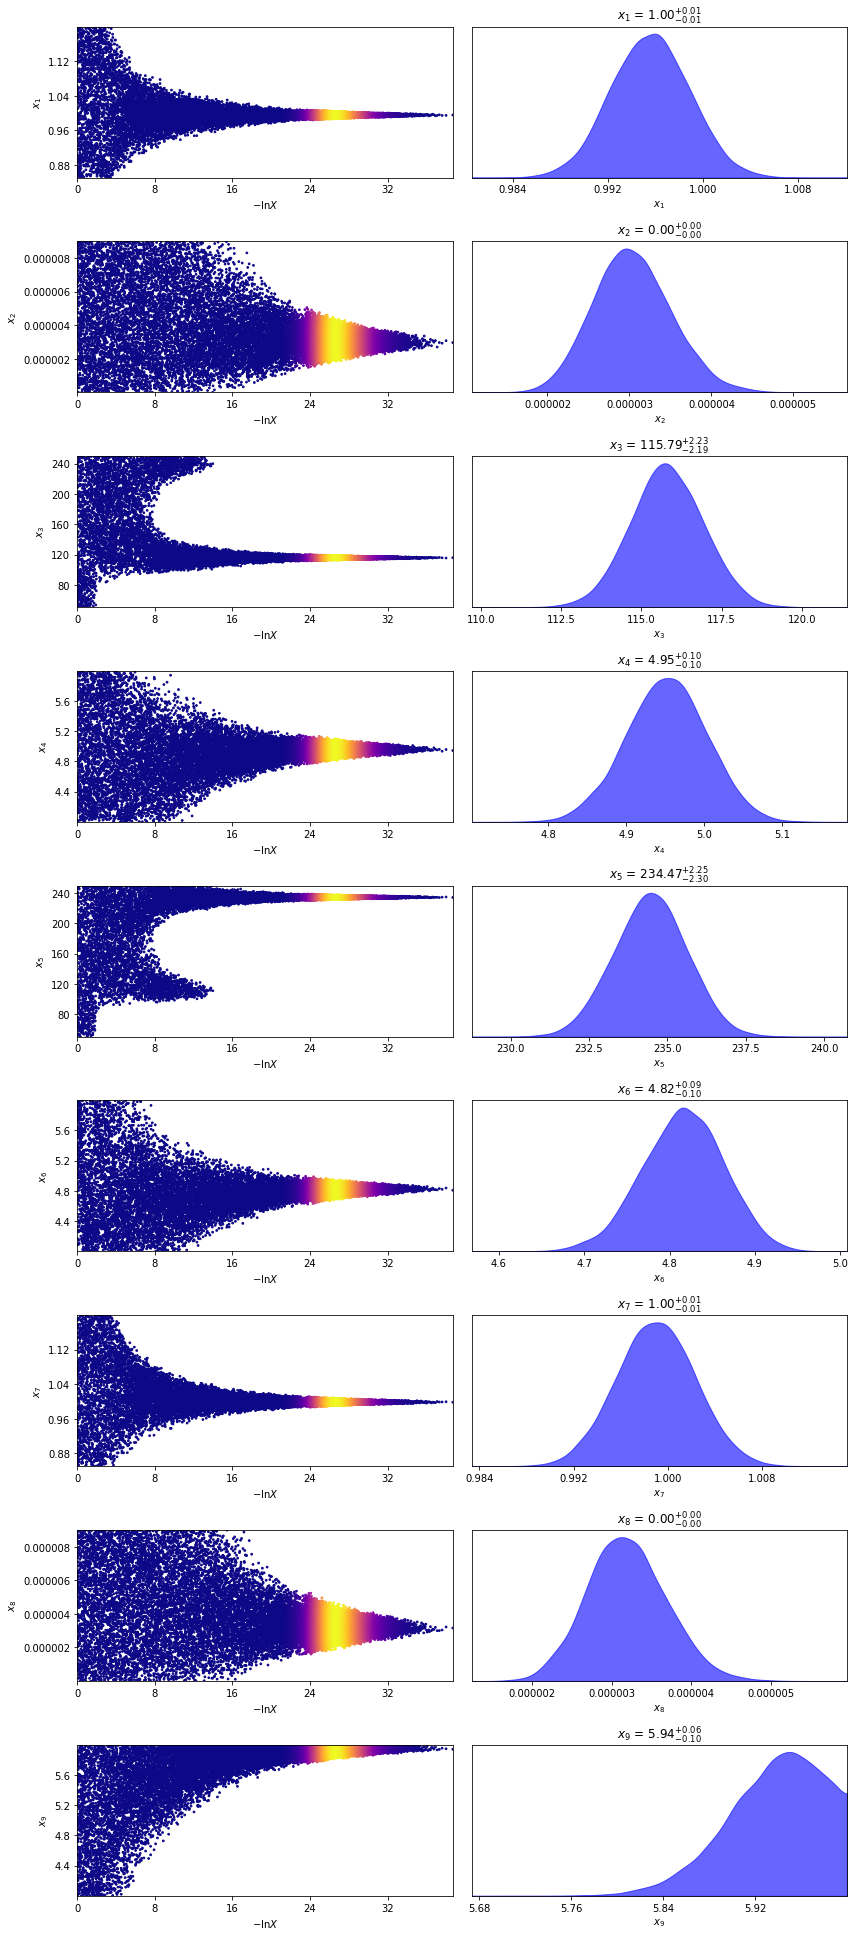

In [27]:
fig, axes = dyplot.traceplot(res21, #truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()

fig, axes = dyplot.traceplot(res22, #truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()

## 3 layered

In [28]:
objective1, structure11, structure12 = gO(data, 3, both=True, globalObjective=True) # was 06:09 now 0:36
fitter = CFitter(objective1)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res31 = DNSampler.results

objective2, structure21, structure22 = gO(data, 3,
                 logpExtra=logp_extra, both=True, globalObjective=True)
fitter = CFitter(objective2)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res32 = DNSampler.results

GlobalObjective and 2 structures


7656it [09:24, 11.13it/s, batch: 0 | bound: 90 | nc: 25 | ncall: 164430 | eff(%):  4.642 | loglstar:   -inf < 111.169 <    inf | logz: 92.873 +/-  0.263 | dlogz: 70.181 >  0.050]      C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
8958it [11:20, 11.99it/s, batch: 0 | bound: 109 | nc: 25 | ncall: 198498 | eff(%):  4.502 | loglstar:   -inf < 151.236 <    inf | logz: 130.953 +/-  0.277 | dlogz: 52.113 >  0.050]C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
9086it [11:36, 11.81it/s, batch: 0 | bound: 112 | nc: 25 | ncall: 203187 | eff(%):  4.461 | loglstar:   -inf < 154.380 <    inf | logz

11019it [15:51, 11.24it/s, batch: 0 | bound: 153 | nc: 25 | ncall: 277868 | eff(%):  3.958 | loglstar:   -inf < 188.403 <    inf | logz: 164.835 +/-  0.300 | dlogz: 25.661 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
11129it [16:13, 11.90it/s, batch: 0 | bound: 156 | nc: 25 | ncall: 284219 | eff(%):  3.909 | loglstar:   -inf < 189.883 <    inf | logz: 165.952 +/-  0.301 | dlogz: 24.326 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely 

13260it [22:38,  8.37it/s, batch: 0 | bound: 199 | nc: 25 | ncall: 393699 | eff(%):  3.364 | loglstar:   -inf < 208.313 <    inf | logz: 181.073 +/-  0.322 | dlogz: 11.773 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
13451it [23:12, 11.93it/s, batch: 0 | bound: 203 | nc: 25 | ncall: 403798 | eff(%):  3.327 | loglstar:   -inf < 209.488 <    inf | logz: 181.881 +/-  0.324 | dlogz: 10.583 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely 

GlobalObjective and 2 structures


8693it [10:57, 11.83it/s, batch: 0 | bound: 105 | nc: 25 | ncall: 191672 | eff(%):  4.524 | loglstar:   -inf < 143.891 <    inf | logz: 123.984 +/-  0.275 | dlogz: 54.746 >  0.050]    C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
9209it [11:51, 11.77it/s, batch: 0 | bound: 114 | nc: 25 | ncall: 207541 | eff(%):  4.427 | loglstar:   -inf < 157.096 <    inf | logz: 136.325 +/-  0.281 | dlogz: 41.370 >  0.050] C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extreme

12332it [18:39, 11.52it/s, batch: 0 | bound: 174 | nc: 25 | ncall: 326868 | eff(%):  3.767 | loglstar:   -inf < 202.069 <    inf | logz: 176.141 +/-  0.314 | dlogz: 14.394 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
12527it [19:18, 11.90it/s, batch: 0 | bound: 178 | nc: 25 | ncall: 338242 | eff(%):  3.698 | loglstar:   -inf < 203.603 <    inf | logz: 177.443 +/-  0.316 | dlogz: 15.632 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely 

previous\
28609it [09:55, 48.06it/s, batch: 8 | bound: 189 | nc: 17 | ncall: 192219 | eff(%): 14.884 | loglstar: 100.123 < 108.366 < 108.319 | logz: 91.440 +/-  0.226 | stop:  0.901]\
pre previous\
29853it [08:20, 59.62it/s, batch: 8 | bound: 162 | nc: 5 | ncall: 145942 | eff(%): 20.455 | loglstar: 1542.518 < 1550.310 < 1548.441 | logz: 1525.116 +/-  0.291 | stop:  0.868]

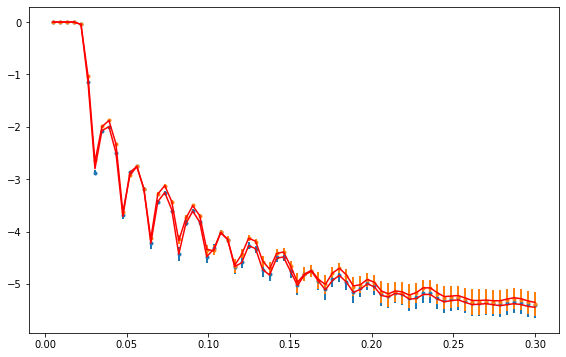

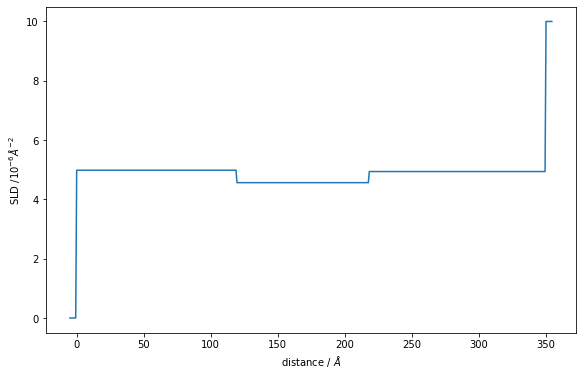

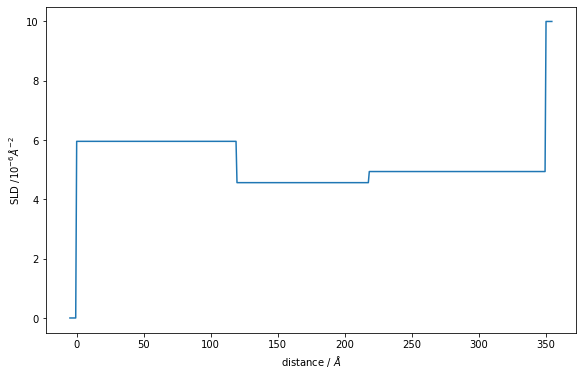

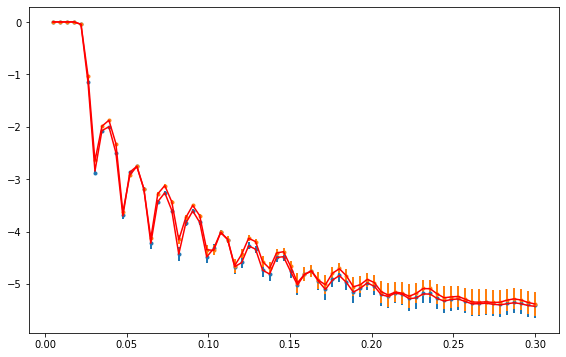

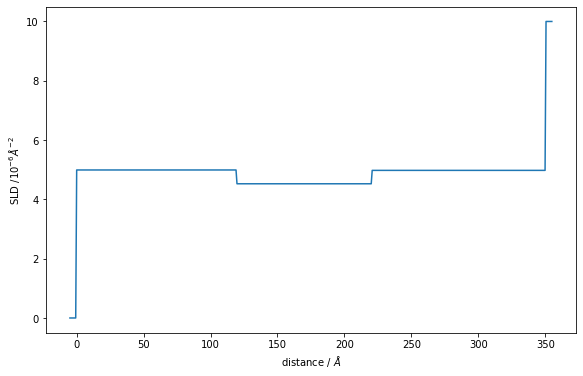

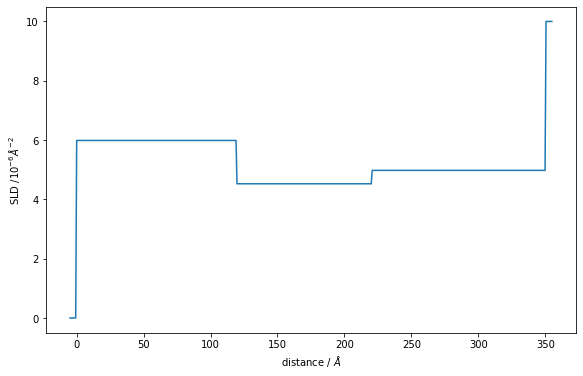

In [29]:
fig, ax = objective1.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure11.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.figure(figI)
figI+=1
plt.plot(*structure12.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

fig, ax = objective2.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure21.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.figure(figI)
figI+=1
plt.plot(*structure22.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

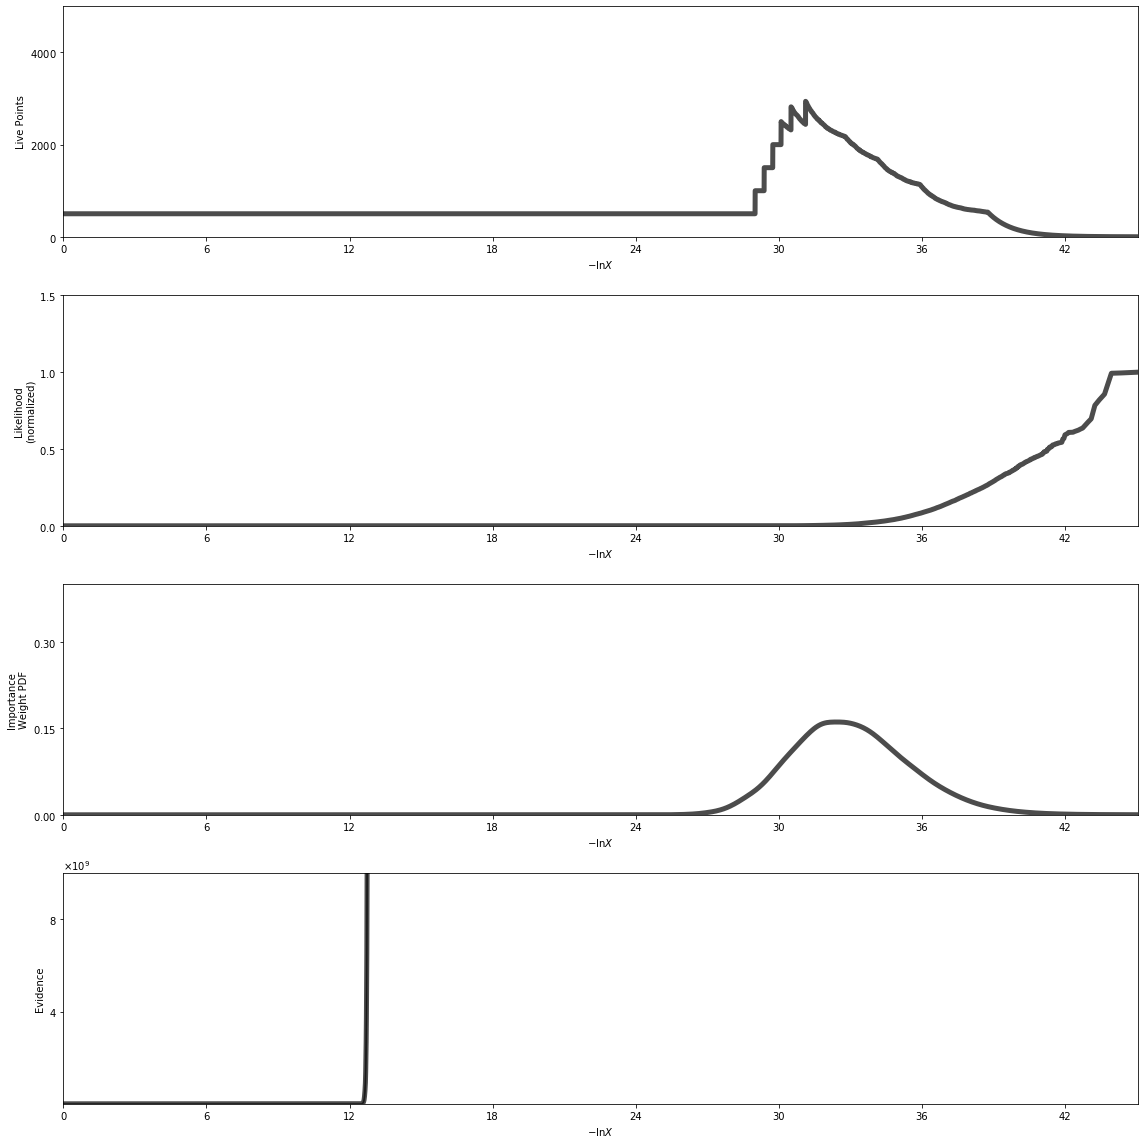

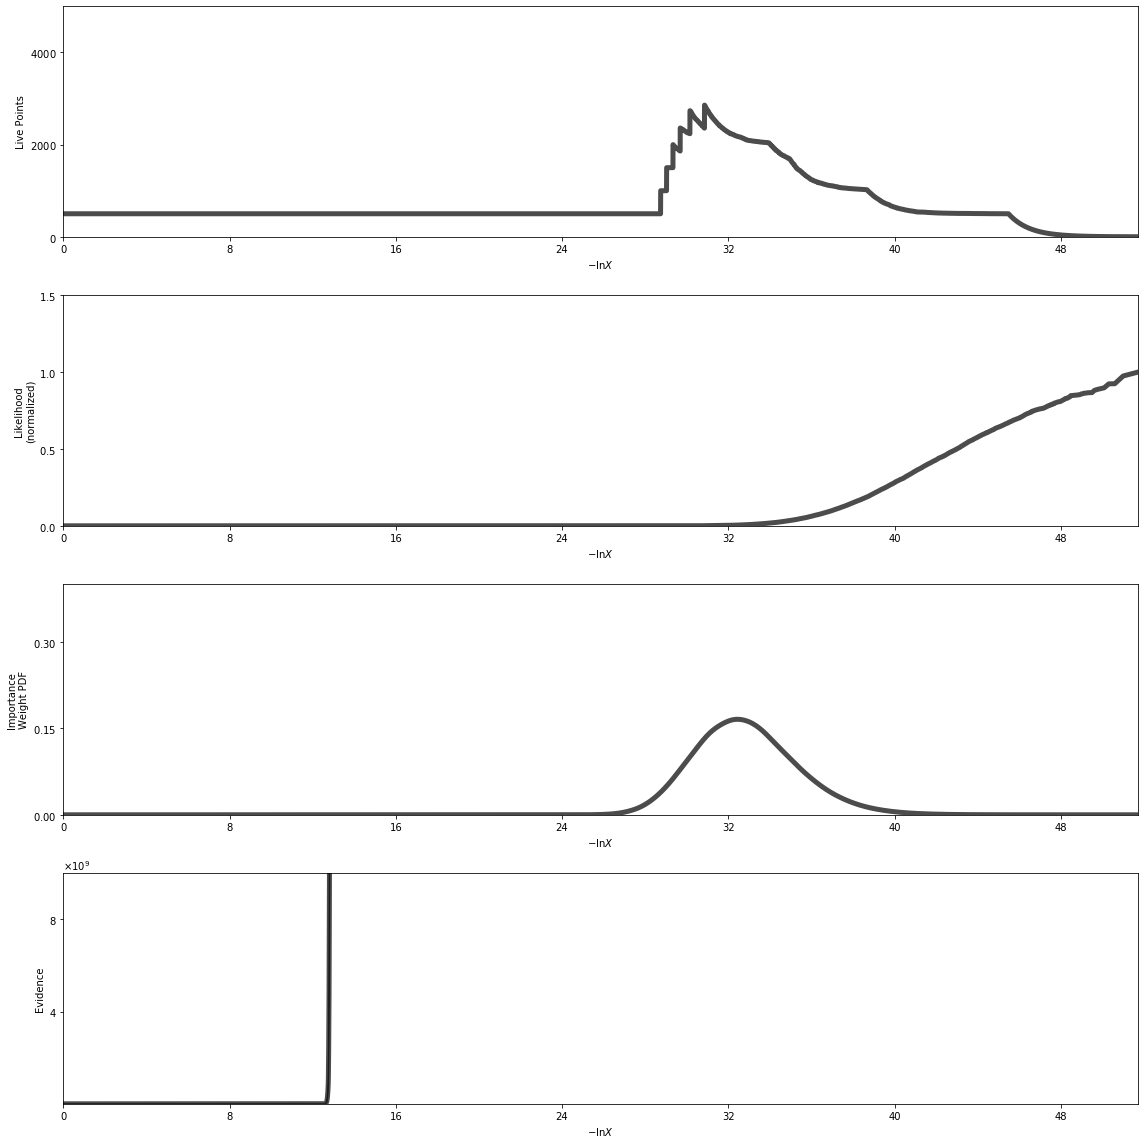

In [30]:
span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**10)]
fig, axes = dyplot.runplot(res31,span=span, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**10)]
fig, axes = dyplot.runplot(res32,span=span, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

limit for interesting values from ln(evidence) >= 0
32
len 30303 space size 45.04210779032861
logz max:  188.43418715208378 ,min:  -74996.91475337652
z max:  6.853740897060622e+81 ,min:  0.0
33
33
len 36382 space size 51.69817304639846
logz max:  188.5418204009679 ,min:  -65355.48753021735
z max:  7.632594817787872e+81 ,min:  0.0
34


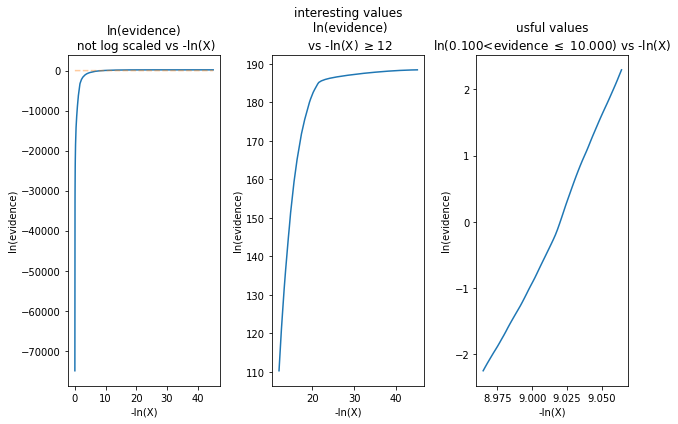

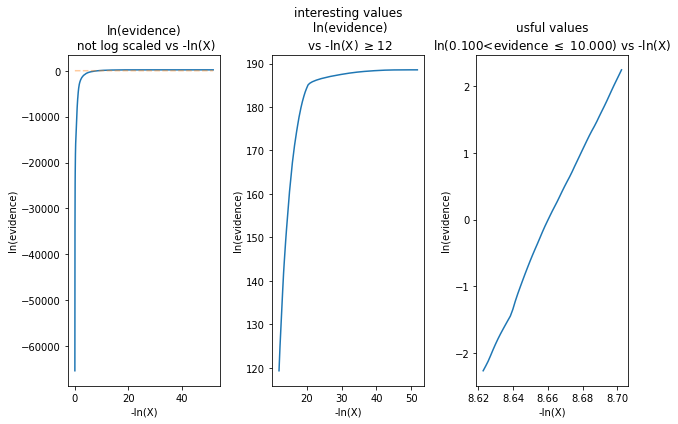

In [31]:
print("limit for interesting values from ln(evidence) >= 0")

figI = aPlotter(res31, min_interesting_lnX(res31), -min(res31["logvol"]), figI)

figI = aPlotter(res32, min_interesting_lnX(res31), -min(res32["logvol"]), figI)

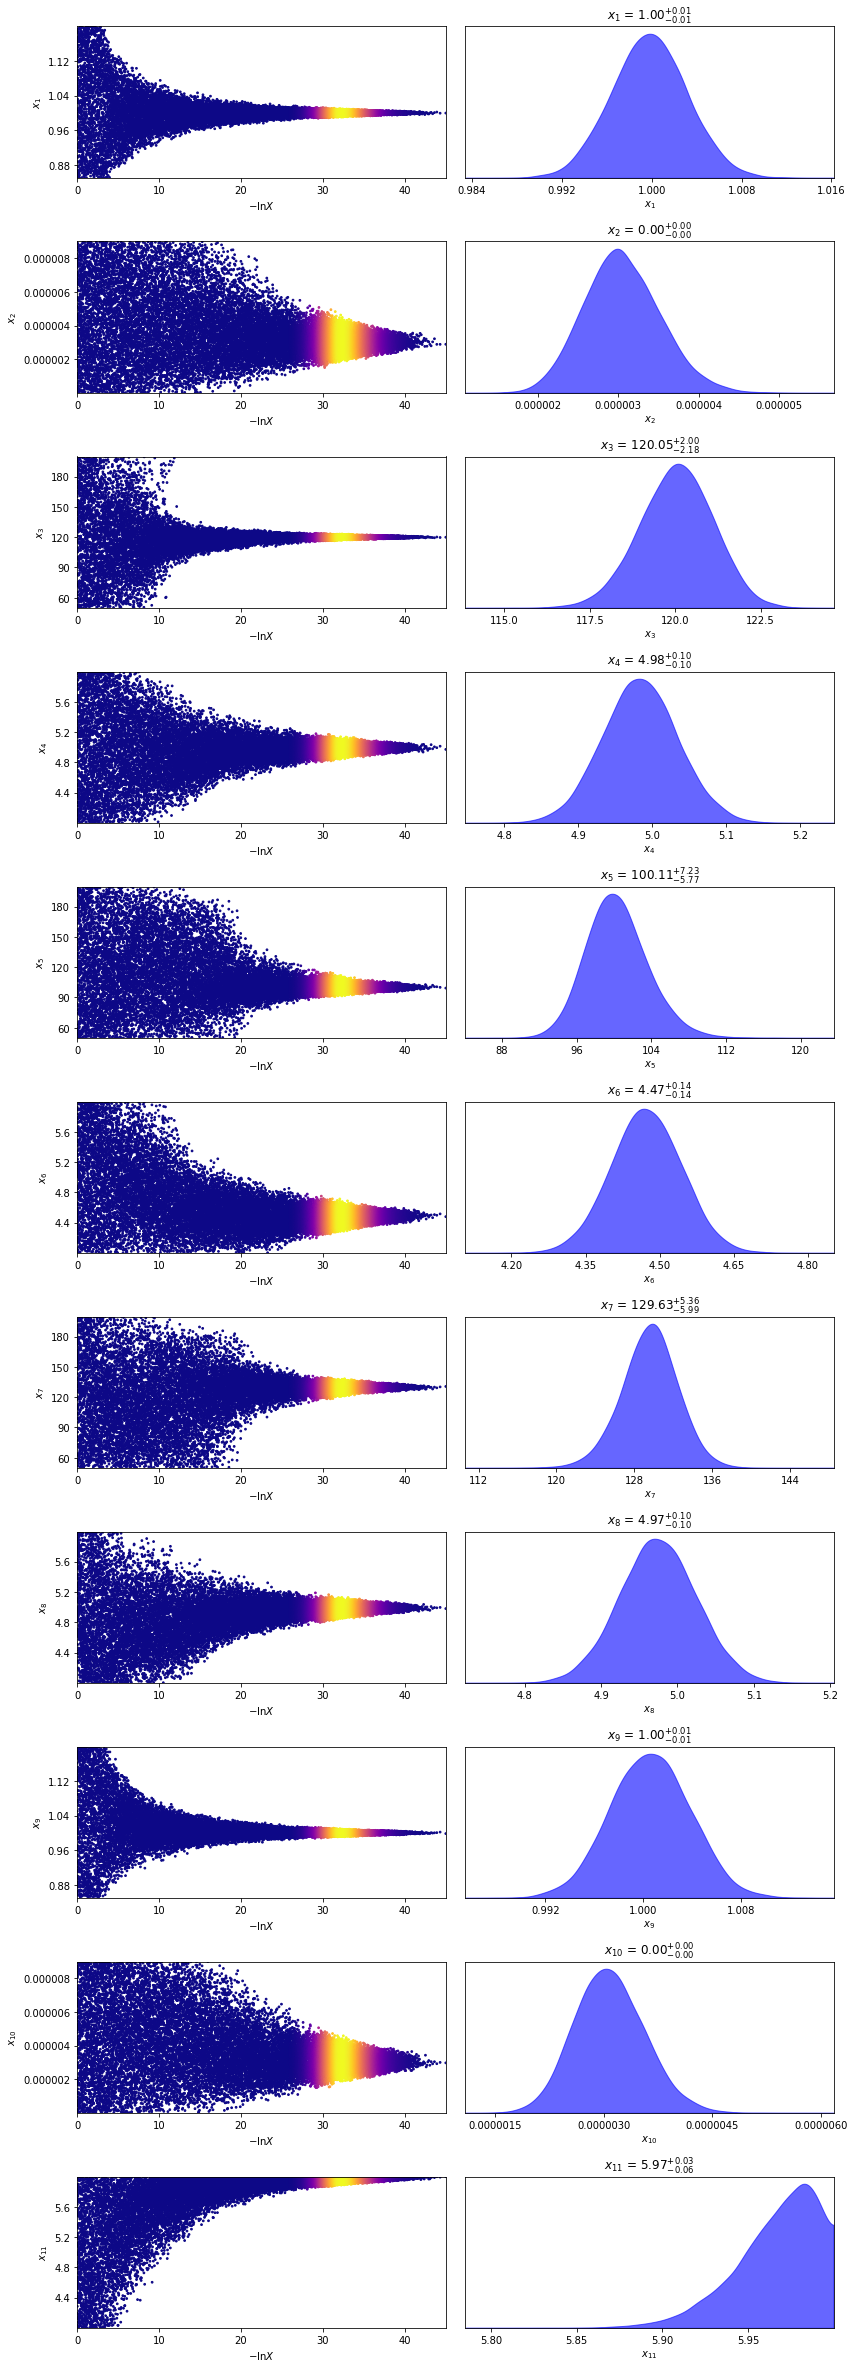

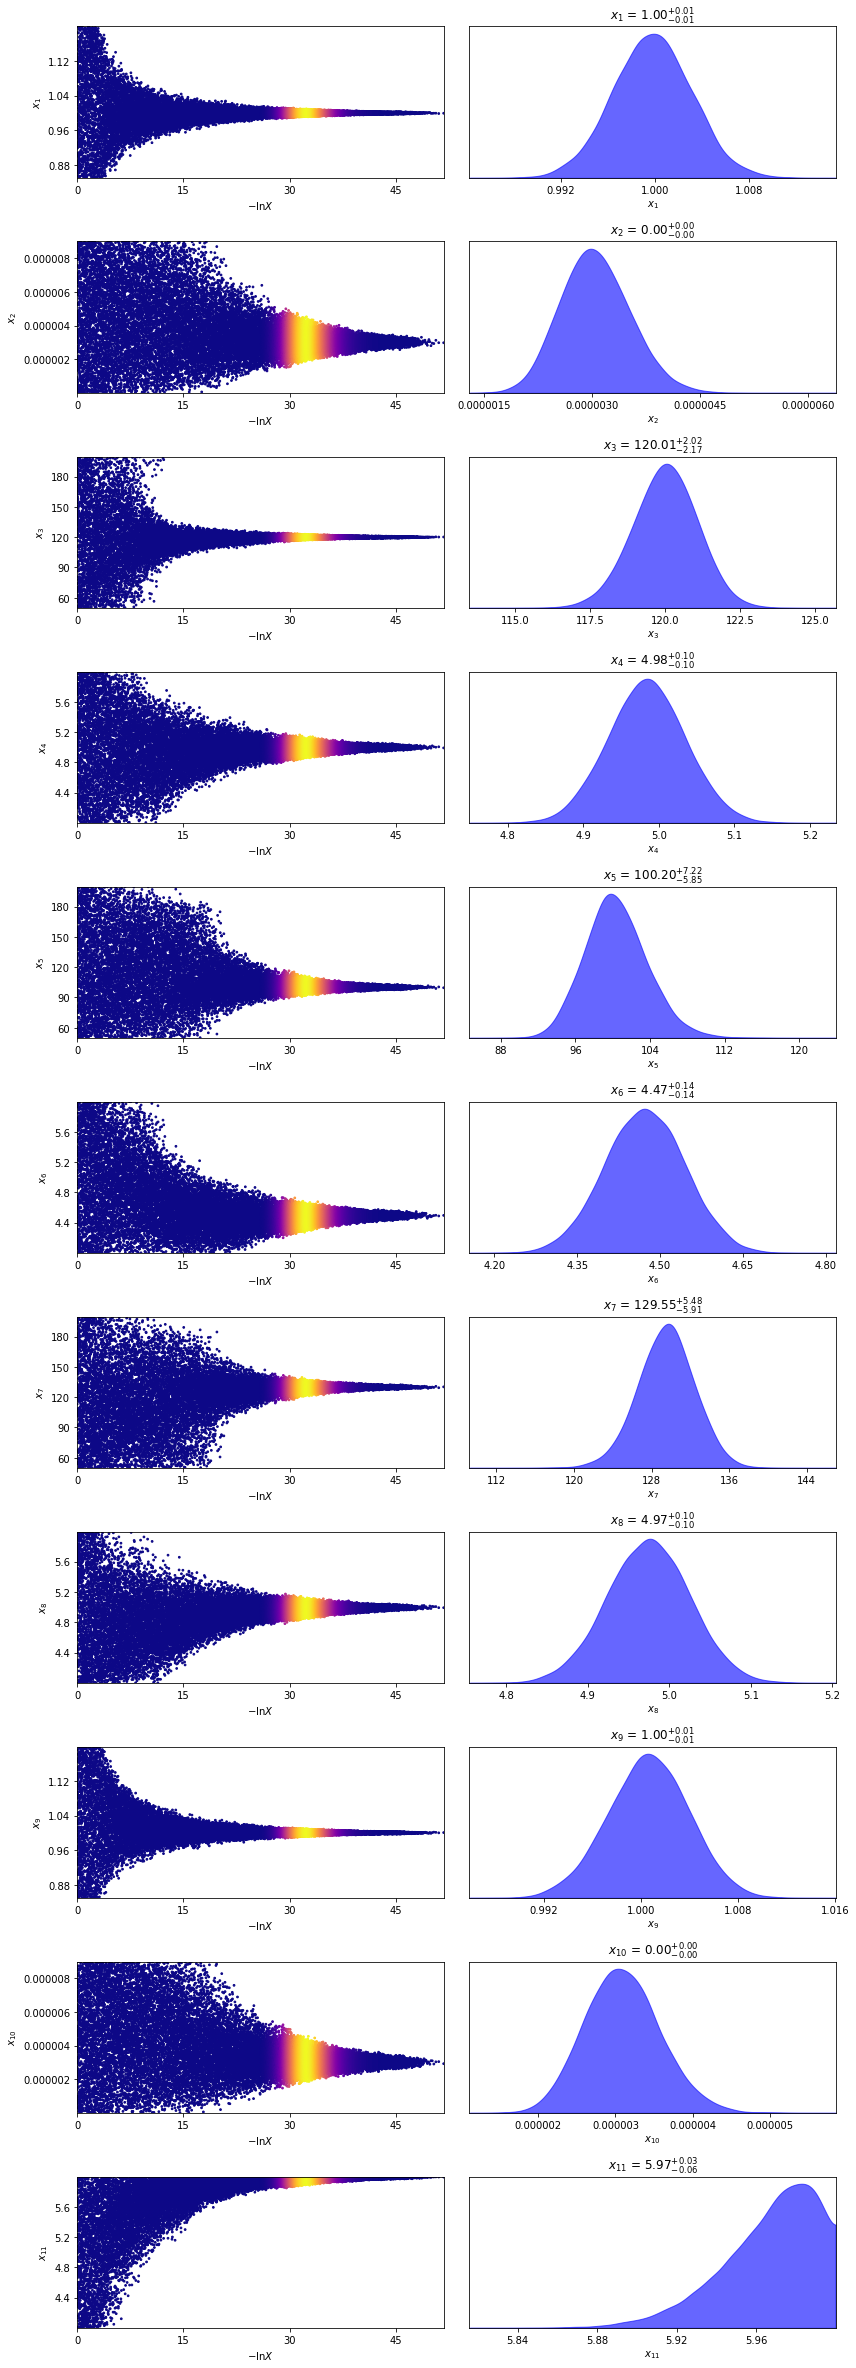

In [32]:
fig, axes = dyplot.traceplot(res31,# truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()

fig, axes = dyplot.traceplot(res32,# truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()

## 4 layered

In [33]:
objective1, structure11, structure12 = gO(data, 4, both=True, globalObjective=True) # was 06:09 now 0:36
fitter = CFitter(objective1)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res41 = DNSampler.results

objective2, structure21, structure22 = gO(data, 4,
                 logpExtra=logp_extra, both=True, globalObjective=True)
fitter = CFitter(objective2)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res42 = DNSampler.results

GlobalObjective and 2 structures


10252it [13:33,  2.61it/s, batch: 0 | bound: 131 | nc: 594 | ncall: 231406 | eff(%):  4.421 | loglstar:   -inf < 162.632 <    inf | logz: 139.951 +/-  0.294 | dlogz: 43.610 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
10323it [13:43, 11.70it/s, batch: 0 | bound: 132 | nc: 25 | ncall: 234228 | eff(%):  4.398 | loglstar:   -inf < 163.919 <    inf | logz: 141.227 +/-  0.294 | dlogz: 42.190 >  0.050] C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
10433it [13:56, 11.63it/s, batch: 0 | bound: 134 | nc: 25 | ncall: 237911 | eff(%):  4.376 | loglstar:   -inf < 166.275 <    inf | l

C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
12263it [18:10, 11.44it/s, batch: 0 | bound: 175 | nc: 25 | ncall: 310510 | eff(%):  3.943 | loglstar:   -inf < 193.201 <    inf | logz: 167.277 +/-  0.315 | dlogz: 23.628 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
12368it [18:27,  9.73it/s, batch: 0 | bound: 178 | nc: 25 | ncall: 315269 | eff(

13965it [23:04, 11.59it/s, batch: 0 | bound: 213 | nc: 25 | ncall: 394526 | eff(%):  3.535 | loglstar:   -inf < 207.426 <    inf | logz: 178.686 +/-  0.331 | dlogz: 13.505 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
14174it [23:31, 11.60it/s, batch: 0 | bound: 217 | nc: 25 | ncall: 402334 | eff(%):  3.519 | loglstar:   -inf < 208.545 <    inf | logz: 179.558 +/-  0.332 | dlogz: 12.215 >  0.050]C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely in

GlobalObjective and 2 structures


8958it [11:31, 11.70it/s, batch: 0 | bound: 112 | nc: 25 | ncall: 197162 | eff(%):  4.532 | loglstar:   -inf < 138.461 <    inf | logz: 117.950 +/-  0.279 | dlogz: 54.344 >  0.050]    C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
9522it [12:23, 11.68it/s, batch: 0 | bound: 120 | nc: 25 | ncall: 211956 | eff(%):  4.482 | loglstar:   -inf < 152.955 <    inf | logz: 131.622 +/-  0.285 | dlogz: 39.538 >  0.050] C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
9687it [12:41, 11.63it/s, batch: 0 | bound: 123 | nc: 25 | ncall: 217078 | eff(%):  4.452 | loglstar:   -inf < 155.909 <    inf | log

C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
12753it [18:46,  7.93it/s, batch: 0 | bound: 183 | nc: 25 | ncall: 321369 | eff(%):  3.962 | loglstar:   -inf < 199.239 <    inf | logz: 172.558 +/-  0.319 | dlogz: 17.160 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
13274it [19:39, 11.67it/s, batch: 0 | bound: 191 | nc: 25 | ncall: 336638 | eff(

previous\
23525it [3:44:24,  1.75it/s, batch: 7 | bound: 6692 | nc: 2 | ncall: 5965849 | eff(%):  0.394 | loglstar: 99.513 < 108.013 < 105.725 | logz: 89.845 +/-  0.233 | stop:  0.930]\
pre previous\
28647it [3:31:10,  2.26it/s, batch: 7 | bound: 4789 | nc: 46 | ncall: 4527187 | eff(%):  0.633 | loglstar: 1542.404 < 1550.302 < 1547.665 | logz: 1522.275 +/-  0.307 | stop:  0.953]  

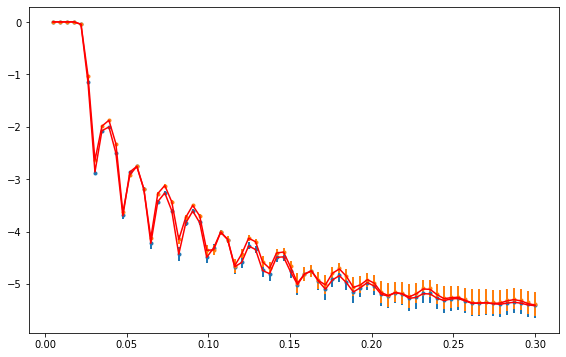

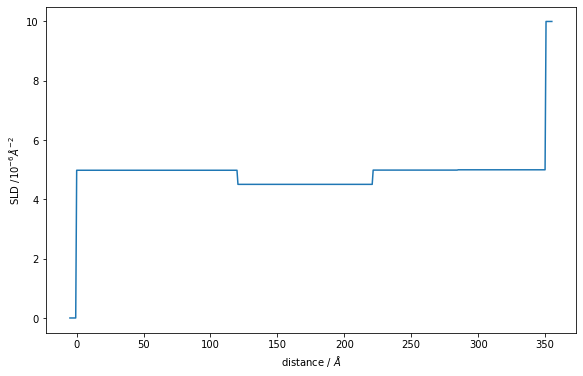

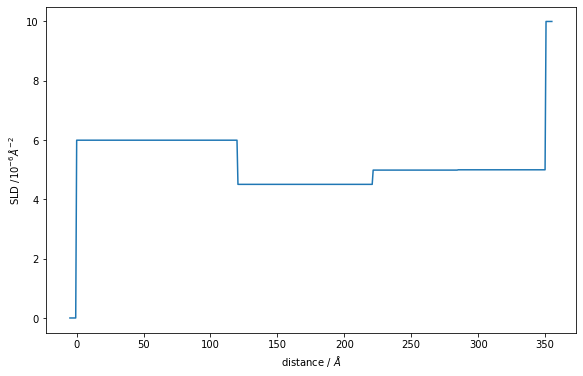

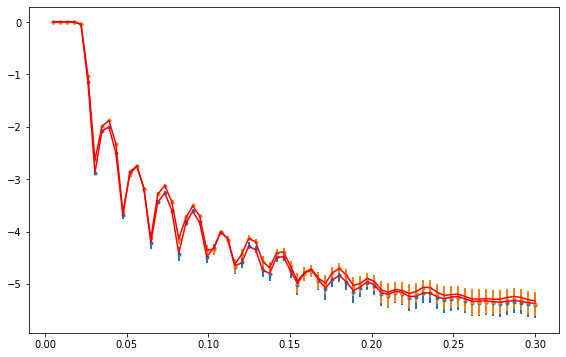

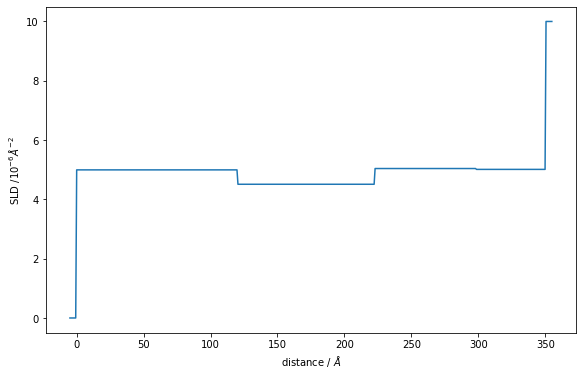

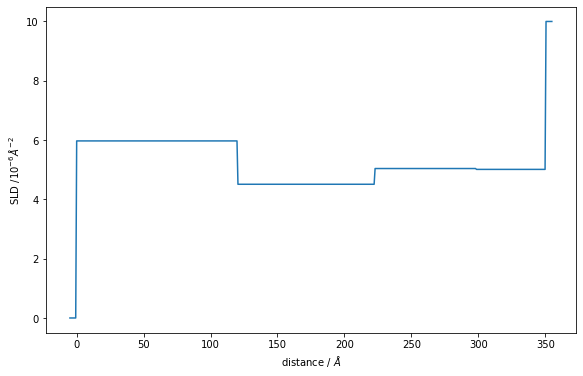

In [34]:
fig, ax = objective1.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure11.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.figure(figI)
figI+=1
plt.plot(*structure12.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

fig, ax = objective2.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure21.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.figure(figI)
figI+=1
plt.plot(*structure22.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

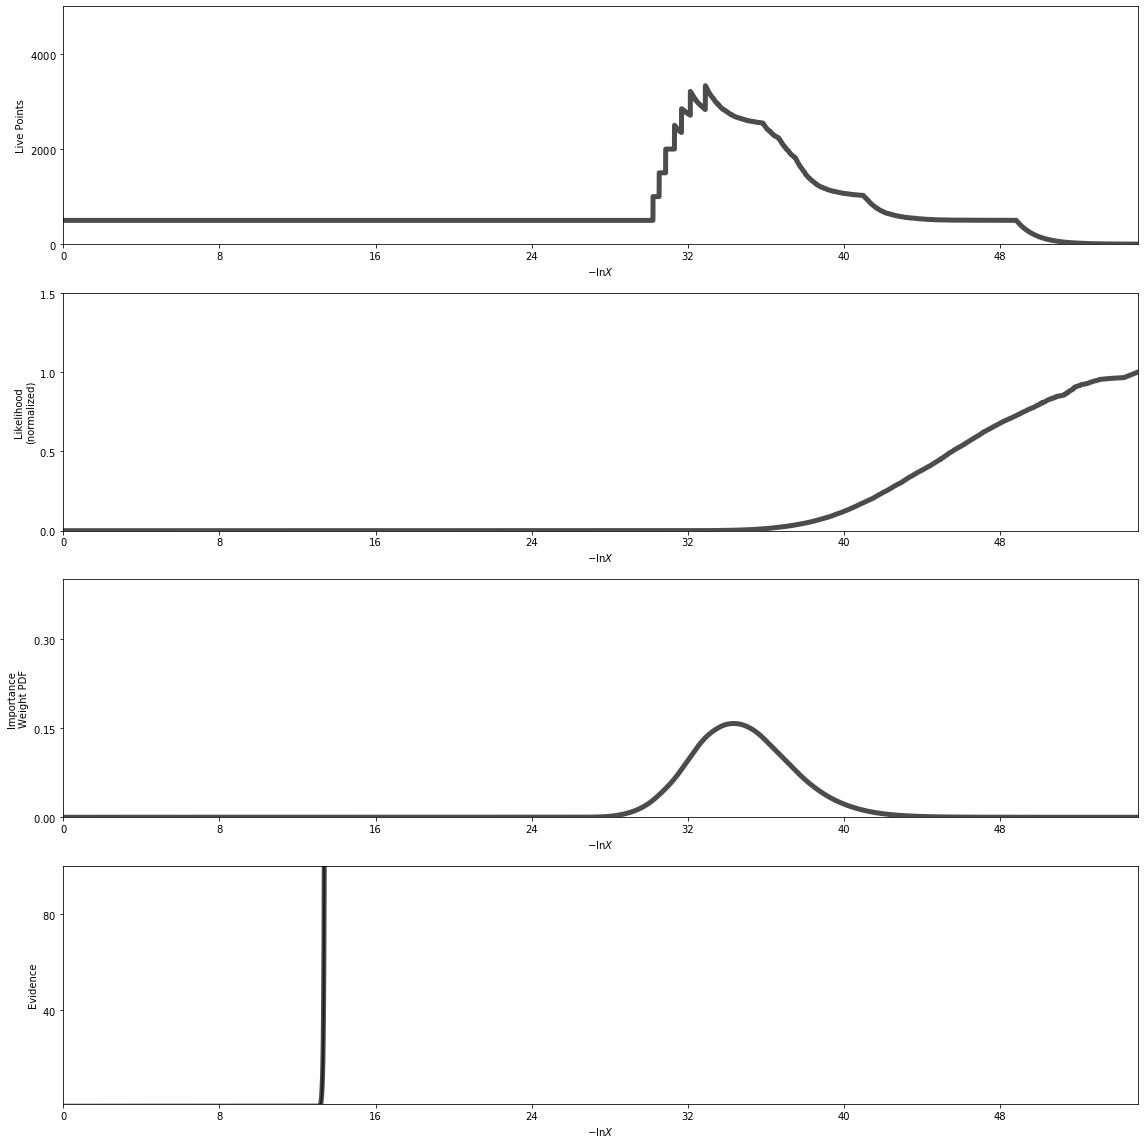

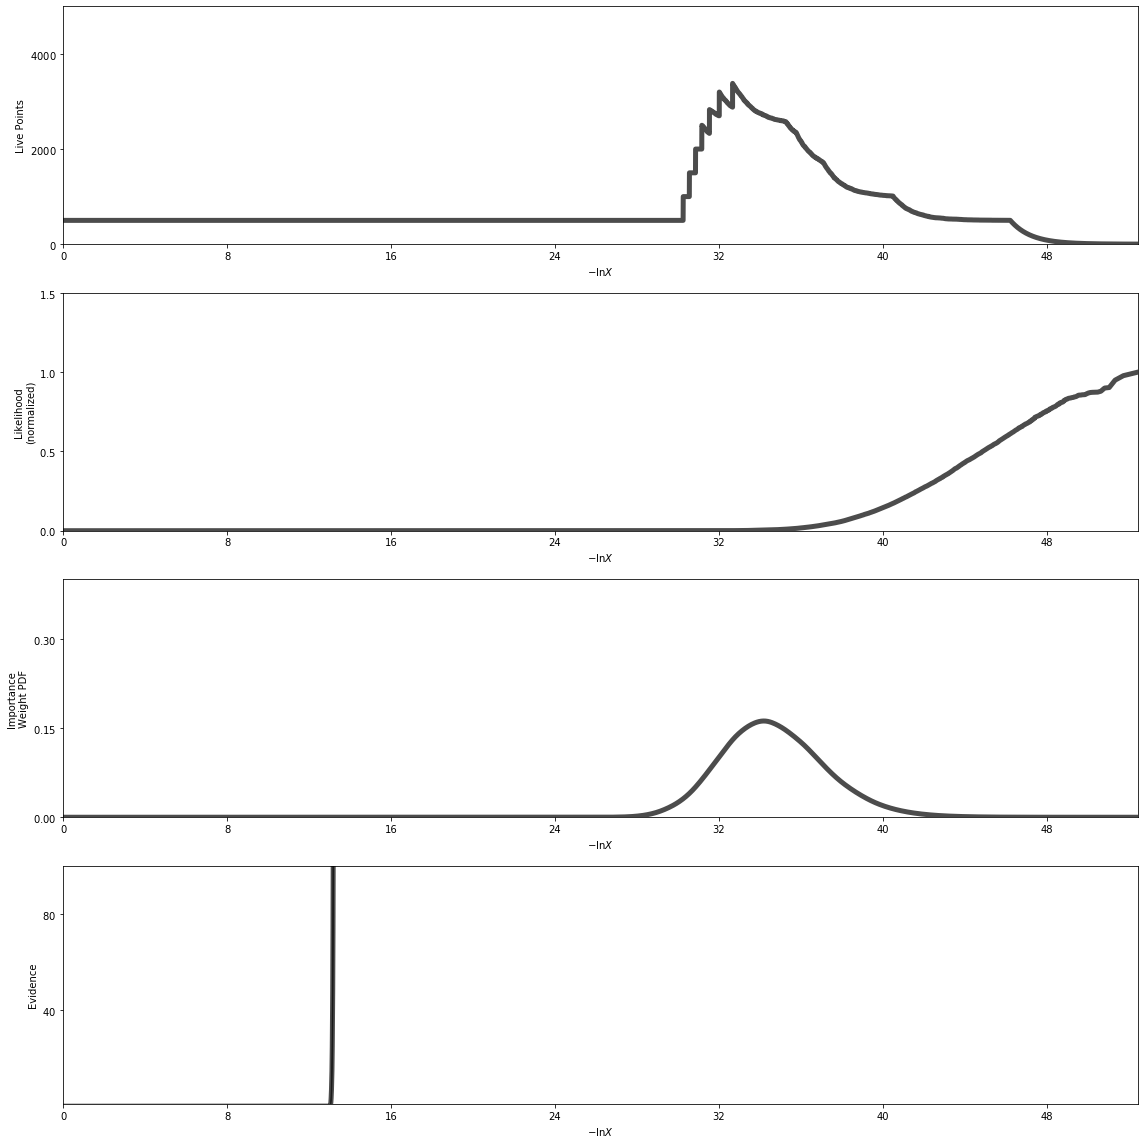

In [35]:
span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**2)]
fig, axes = dyplot.runplot(res41,span=span, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**2)]
fig, axes = dyplot.runplot(res42,span=span, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

limit for interesting values from ln(evidence) >= 0
40
len 42273 space size 55.03486584646885
logz max:  186.2126567647295 ,min:  -67416.38456889514
z max:  7.432403744662462e+80 ,min:  0.0
41
41
len 39798 space size 52.44243807355614
logz max:  186.40140337009495 ,min:  -68594.51346209897
z max:  8.976373245915708e+80 ,min:  0.0
42


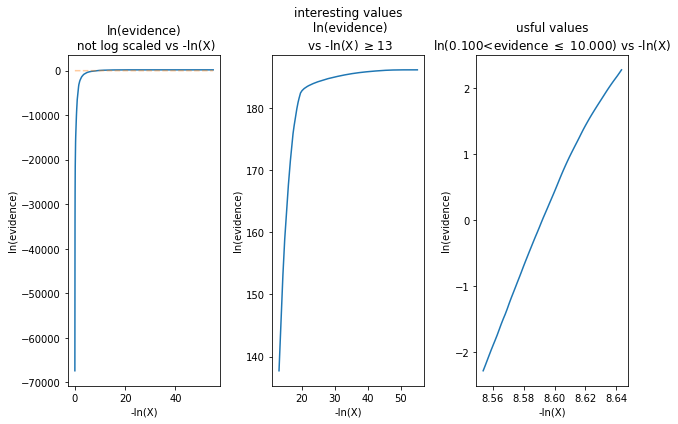

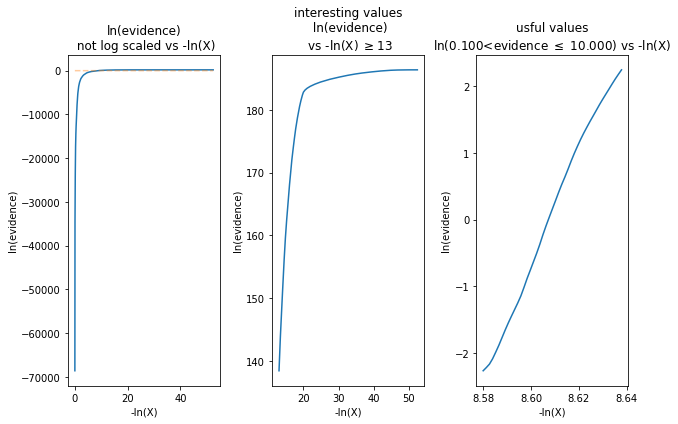

In [36]:
print("limit for interesting values from ln(evidence) >= 0")

figI = aPlotter(res41, min_interesting_lnX(res41), -min(res41["logvol"]), figI)

figI = aPlotter(res42, min_interesting_lnX(res42), -min(res42["logvol"]), figI)

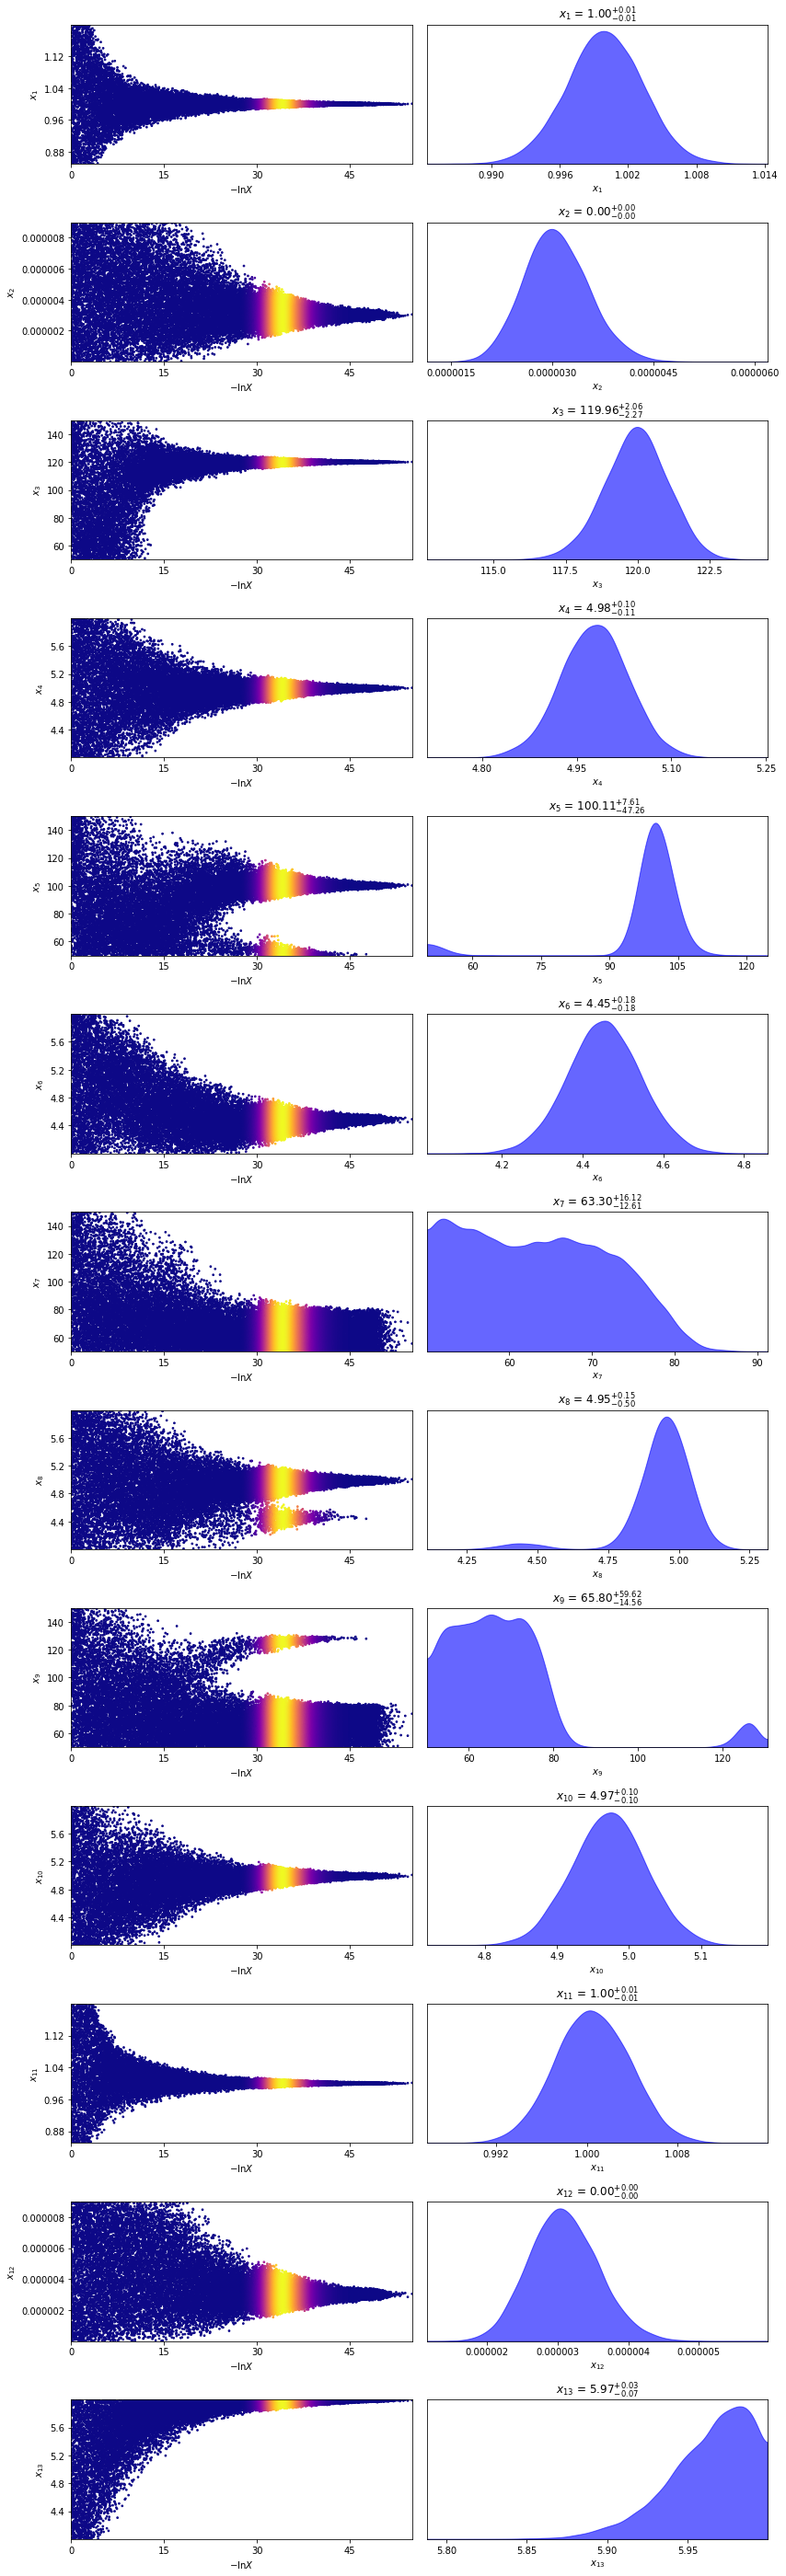

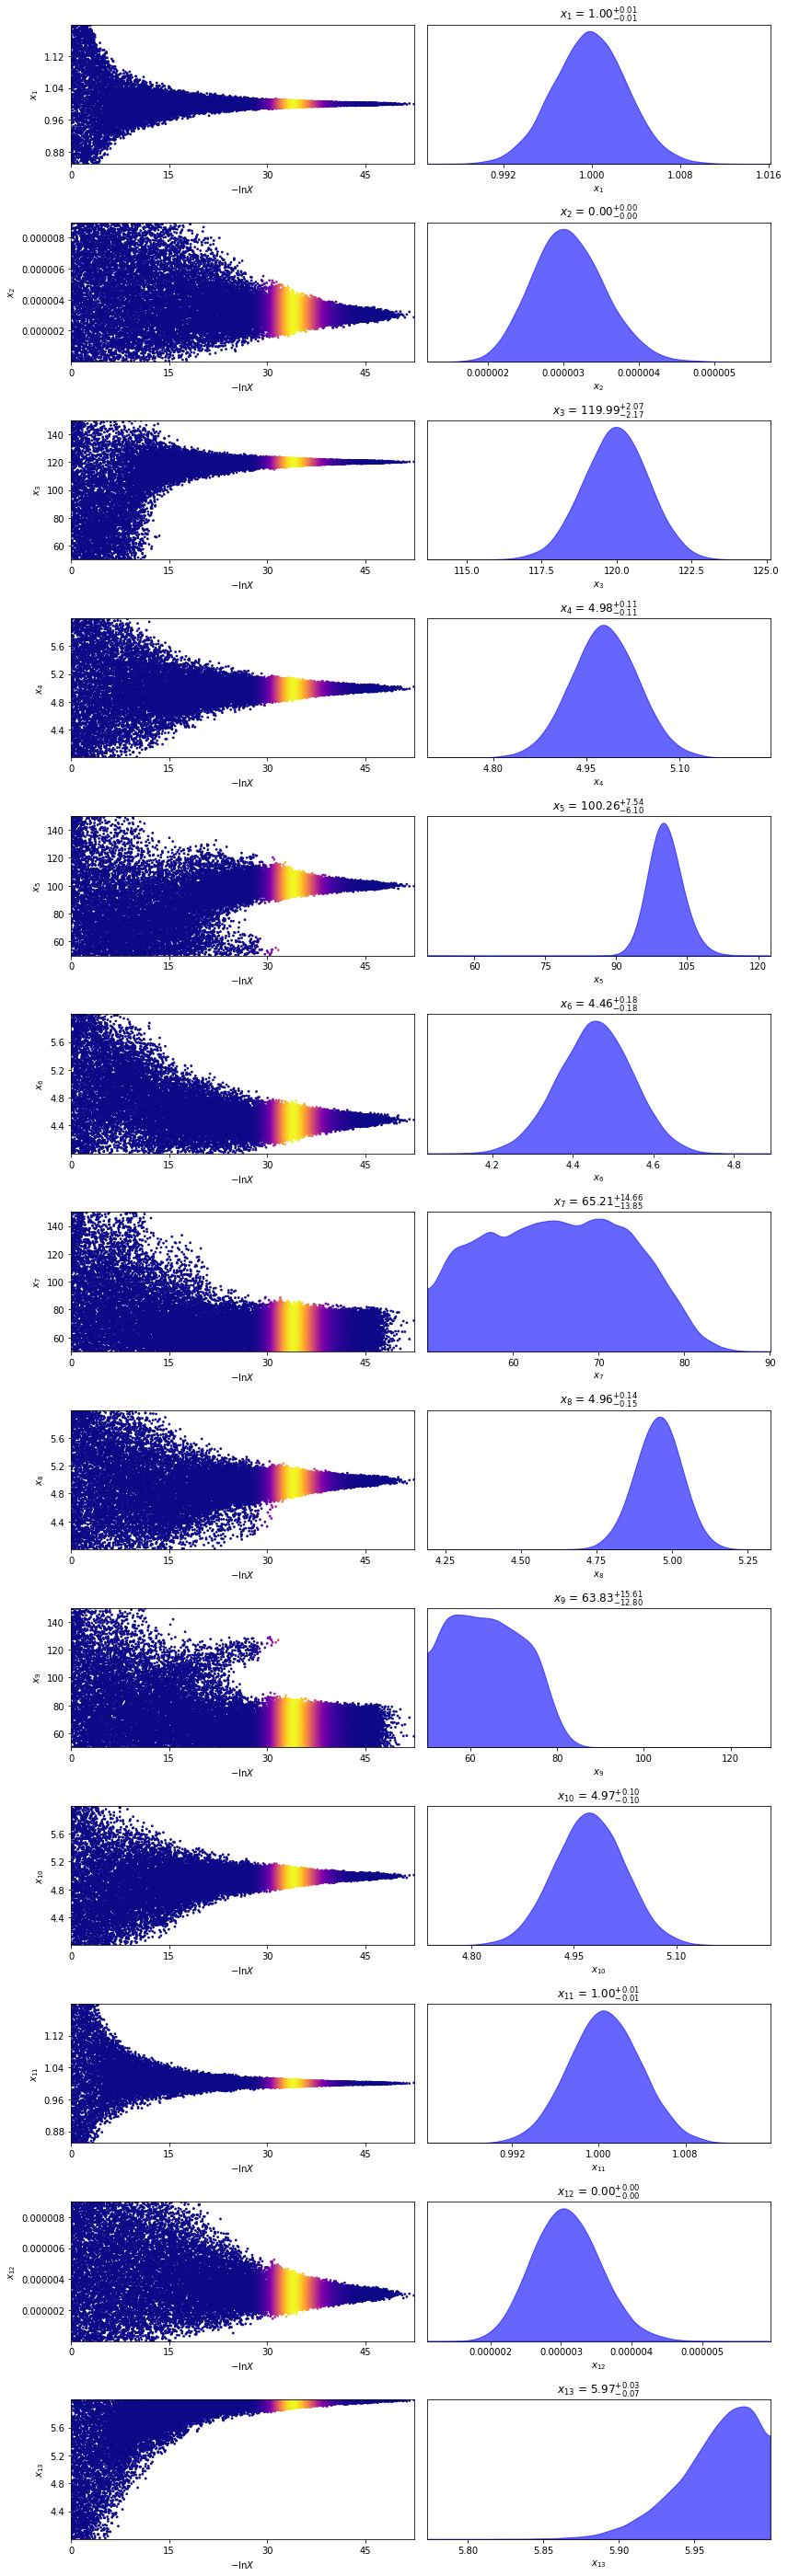

In [37]:
fig, axes = dyplot.traceplot(res41,# truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()

fig, axes = dyplot.traceplot(res42,# truths=np.zeros(fitter.nDim()),
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()